<a href="https://colab.research.google.com/github/sebastienlange/dermatologist-ai/blob/master/dermatologist_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook, I'm designing an __algorithm that can visually diagnose melanoma, the deadliest form of skin cancer__. In particular, the algorithm will try to distinguish this malignant skin tumor from two types of benign lesions (nevi and seborrheic keratoses).  

I also share how I turned my mistakes into __positive learning experiences__!

# Getting Started

This notebook can be easily run on [Google Colab](https://colab.research.google.com/github/sebastienlange/dermatologist-ai/blob/master/dermatologist_ai.ipynb) with GPU activated:  
[<img src="https://colab.research.google.com/assets/colab-badge.svg">](https://colab.research.google.com/github/sebastienlange/dermatologist-ai/blob/master/dermatologist_ai.ipynb)

If you've got any feedback, https://github.com/sebastienlange/dermatologist-ai is the place to leave it. Bug reports, questions, general feedback, and even feature requests are all welcome - just create an [issue](https://github.com/sebastienlange/dermatologist-ai/issues).

Want to give your feedback in private? You can email me on lange.sebastien@gmail.com.

![title](https://github.com/sebastienlange/dermatologist-ai/blob/master/images/skin_disease_classes.png?raw=1)

I personnally mounted my own Google Drive for easiness and download/upload's performance.  

I understood it late, but I finally saved the best trained models directly to my Google Drive. I do not need to think about it anymore and when I reach the limit of 12 consecutive hours of Google Colab ... I do not lose my models stupidly! It happened a few times 😉

In [1]:
import os

google_drive_mount_path = '/content/gdrive'
google_drive_shared_path = os.path.join(google_drive_mount_path, 'My Drive' , 'dermatologist-ai')

def mount_google_drive():
  
  from google.colab import drive
  drive.mount(google_drive_mount_path)
  
mount_google_drive()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Install Prerequisites

In [2]:
# google colab does not come with torch installed.
!pip install -q torch==1.0.0 torchvision

# display live plots while training (loss, accuracy, ROC AUC...)
!pip install -q livelossplot==0.3.3

    100% |████████████████████████████████| 591.8MB 29kB/s 


# Download Data

In [0]:
import pandas as pd
import numpy as np

phases = ['train', 'valid', 'test']
data_root = os.path.join(os.getcwd(), 'data')
data_dir = {phase:os.path.join(data_root, phase) for phase in phases}

In [4]:
# download train.zip, valid.zip, test.zip
for phase in phases:
  url = f'https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/{phase}.zip'
  !wget -nc $url -P $data_root

--2019-04-18 13:22:39--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.16
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5736557430 (5.3G) [application/zip]
Saving to: ‘/content/data/train.zip’

train.zip           100%[===================>]   5.34G  26.8MB/s    in 3m 35s  

2019-04-18 13:26:14 (25.5 MB/s) - ‘/content/data/train.zip’ saved [5736557430/5736557430]

--2019-04-18 13:26:15--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.24.45
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.24.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 864538487 (824M) [application/zip]
Saving to: ‘/content/data/val

In [0]:
import zipfile

from tqdm import tqdm_notebook as tqdm

In [6]:
# unzip train.zip, valid.zip, test.zip
for phase in phases:
  if not os.path.exists(data_dir[phase]):
    with zipfile.ZipFile(os.path.join(data_root, f'{phase}.zip'), 'r') as myzip:
      for file in tqdm(myzip.namelist(), desc=f'Extracting {phase}.zip'):
        myzip.extract(member=file, path=data_root)

# Explore Data

In [7]:
import glob

classes = [path.split(os.path.sep)[-1] for path in sorted(glob.glob(os.path.join(data_root, 'train', '*')))]
classes

['melanoma', 'nevus', 'seborrheic_keratosis']

These are our 3 classes! Let's now explore how much data we have and how it's distributed:

In [0]:
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

def print_images_distribution(plot=False):

  image_repartition = pd.DataFrame(index=[d.split(os.path.sep)[-1] for d in data_dir.values()], columns=classes)
  plot_data = pd.DataFrame(columns=['Class', 'Phase', 'Count'])
  
  for phase in [d.split(os.path.sep)[-1] for d in data_dir.values()]:
    for disease in classes:
      count =  len(glob.glob(os.path.join(data_root, phase, disease, '*.jpg')))
      image_repartition.loc[phase][disease] = count
      plot_data = plot_data.append({'Class': disease, 'Phase': phase, 'Count': count}, ignore_index=True)

  image_repartition.loc['TOTAL'] = image_repartition.sum(axis=0)          
  image_repartition['TOTAL'] = image_repartition.sum(axis=1)
  image_repartition['Ratio'] = np.round(image_repartition.TOTAL / (image_repartition.TOTAL.sum() - image_repartition.TOTAL[-1]), 2)
  
  if plot:
    sns.set_style("whitegrid")
    sns.barplot(x='Class', y='Count', hue='Phase', data=plot_data, palette='Blues')

  return image_repartition

,melanoma,nevus,seborrheic_keratosis,TOTAL,Ratio
train,374,1372,254,2000.0,0.73
valid,30,78,42,150.0,0.05
test,117,393,90,600.0,0.22
TOTAL,521,1843,386,2750.0,1.00


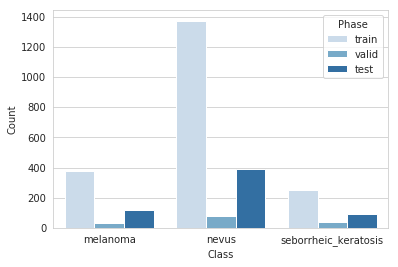

In [9]:
print_images_distribution(True)

## Class imbalance
We have a __class imbalance problem__ in this dataset: __nevus is much more represented__ whereas we are interested to have a great accuracy in the prediction of melanoma and seborrheic_keratosis.  

Without any change, the model would just learn to predict nevus. (My first mistake 😉)

## Download more data

Fortunately, we can __download more samples__ from [ISIC Archive](https://www.isic-archive.com/#!/onlyHeaderTop/gallery).  

So let's download more samples and ensure we don't have any duplicate!


In [0]:
data_dir['more'] = os.path.join(data_root, 'more')

The additional data is stored publicly on my personal Google Drive.

In [0]:
google_drive_download_link = 'https://drive.google.com/uc?export=download'

additional_image_files = {
                          # additional images downloaded from https://www.isic-archive.com/#!/onlyHeaderTop/gallery
                          'melanoma-1.zip': '10Wo3RwSC-O4YEAZkU77ZehciDpWCn3Si',
                          'melanoma-2.zip': '1L9XLBX1sIYX9GiEdfhWizeOuP52Pdgm2',
                          'melanoma-3.zip': '1jP7YCh5e2g588f0j5ikURsU7oNCLtQCL',
                          'melanoma-4.zip': '1_IjF2lZZE2yeaZSE9rXqrfrgXd_UdKZi',
                          'melanoma-5.zip': '1KRF0zRWU-yGSa87p04kQvCHvTiCnZnOO',
                          'melanoma-6.zip': '1vL18GGPxNCY--R-VLoFRqxeI2ZiSfTJi',
                          'melanoma-7.zip': '1bFoqLrcUu1YwYq5EQxMrg7WQjRRHNA8U',
                          'melanoma-8.zip': '1tFW8OkvpWyXpm0ueeCld0qG5k6uk7q3X',
                          'nevus-1.zip': '1GqBasxjZJNh_C8B4uWaxGLbvDU3HE0e3',
                          'nevus-2.zip': '1H7PDGPnCapqwmYY2FYaSp1ppqMg9W72a',
                          'nevus-3.zip': '1snmb9zMdcAjVxW9sRpduMbP9gf3gUqGh',
                          'nevus-4.zip': '1KFDlx1W8AC97hzTRvVvQJ29EoUiH78pQ',
                          'seborrheic_keratosis.zip': '1wTgY_AFo0wLF-0g-2mxzkwAv2EXmpGq1',
}

# my own pretrained models
trained_models_files = {               
    'DenseNet.pt': '1c83tG5-fvTQsRB-N-ADLXwG7_W3mbiwr',
    #'DenseNet_1_0.9061.pt': '1-YVLYq4s5IKrCMF4_S5YU8I6iUFAt77U',
      
    #'Inception3.pt': '17NFK86u9V1sbc-048CzsBSzGwsLSdrqT', 
    #'Inception3_1_0.9044.pt': '1-sE7S8Dfn7qdpxdQoYF7a03KvGhiQAy9',
    #'Inception3_1_0.9033.pt': '1-q5NysUfpce_9h_38H7iEa-w4nZ2pPlh',
    'Inception3_3_0.9051.pt': '1-4-NBGjBzaVLbdKyQYU35JsG7hH9dmpD',
    'Inception3_3_0.9089.pt': '1-BE3K5jyDZ21rsFpIG_22GfrCvriLM_G',
    #'Inception3_5_Mixed_5c_0.9090.pt': '1-5CPkvlJNOCjgP0Zh4iEPdkOyE0M4ZN_',
          
    'NASNetALarge.pt': '144_os2xtFyN9RDH-1cYiXfRd1p5hA-Gn',
    'NASNetALarge_4_0.9106.pt': '1JJLyVraQc8ojllTdU4LyyVo5mkpFtq-3',
    #'NASNetALarge_3_0.9039.pt': '1-FEos4JEc55px6xPDAVkQ-q_jHtPLwy3',
    #'NASNetALarge_2_0.9084.pt': '1kt4hEKIJHbv1Qq0RBROHJgh_c_nhsGIS',
    
    'Xception_1_block4_0.9076.pt': '1WYvzipY-pR5Db6b2bkI8BDfv9HLc1PNt',
    'Xception_1_block4_0.9120.pt': '1308ZVjdOsMe_voKRQ5wdejMapa01g1cK',
    #'Xception_2_block3.rep.4_0.9048.pt': '1ymSI0vAhIIyamzPlFlbuVsVQGbE1KP4z',
    #'Xception.pt': '1hOcWopW_53SB0Nmoh1QjMVDGOusryRGA',
    #'Xception_2_0.9005.pt': '1z2KKYtc9WU2IaAdcLK1WPV552ylPgH8A',
    #'Xception_1_0.9046.pt': '1-EEbna_D8cXDVbHHmtHia-i8Ztg-CUBr',
    #'Xception_3_0.9004.pt': '1Cx4yGcbAR0A3mtkGmpS32Pbgi9o7RNZo',
    #'Xception_3_block4_0.9130.pt': '1GR3X0cIN7IbuWQWlQZu9LBEGHDgShOrd',
    #'Xception_1_block4_0.9122.pt': '1yrdQDQRIwsfZuYYvttl-i0gpWElej1_D',
      
    #'SENet_1_0.9011.pt': '1--kULUlWI6McXS0gtWHGYtYgm2LivGql',
    #'SENet_2_0.9060.pt': '1oDU8Tk7iVEyikJYTl4QGtWHG2Gm3FpRF',
    'SENet_3_layer2.1_0.8988.pt': '1--Q3L7DkuHL3Qr8A6gJZIcP1FiOiMQm_',
      
    #'InceptionV4_5_0.9018.pt': '1God6sryoRu5PgdRrzgyvo-8UtgiU51Pg',
    #'InceptionV4_5_0.9047.pt': '1-19ShakenoaRGK0JCRbtCK4f9FAvFjJz', 
    #'InceptionV4_1_features.6.branch2.0_0.9033.pt': '1-8wALop8bWb0n_nDyVo-1BY7_QcjdW8q', 
    #'InceptionV4_2_features.6.branch1.0_0.9030.pt': '1-0CmdsF_wiZPJk9mfeFj4hlD05lfr54p', 
    'InceptionV4_2_features.6.branch1.0_0.9117.pt': '1-0EXqfAEqO_sqeWW3X7Po6-yRbbVkVyu', 
    #'InceptionV4_2_features.6.branch1.1_0.9021.pt': '126GnetETRfEbQf43GtUfQKihkw7cEVoR', 
    
    #'InceptionResNetV2_2_repeat.0.branch2.1_0.8869.pt': '1bQyaMoI3QfoEOLYNsitIsUCuQM4EwU6W',
    #'InceptionResNetV2_2_repeat.0.branch2_0.8898.pt': '1lMsnmDJFoT-xTeUM6UC3axTSaL5f9F0K',
    #'InceptionResNetV2_5_repeat.0.branch1.1_0.8908.pt': '1wyLd2E23Iv1W7rSjfDThYsuZzX0oWJLd',
    'InceptionResNetV2_2_repeat.0.branch2_0.8966.pt': '1lMsnmDJFoT-xTeUM6UC3axTSaL5f9F0K',
    #'InceptionResNetV2_3_repeat.2.branch1.0_0.8828.pt': '1-0ibA34wsAnGJQAsbVVe6_0mSKLTWfmy',
    #'InceptionResNetV2_4_repeat.0.branch1.1_0.8901.pt': '1S-OySYg1yRzCqSHZ3O9_ExsFUmXiHomW',
    
    #'PolyNet_1_stage_a.7_0.8488.pt': '1-79sulu1-RmLytcgBSOGkkm-G_vo8O8w',
    
    #'PNASNet5Large_2_cell_2_0.8910.pt': '1-DSvAqQ0HlTZlu0znlcNznkuIZCotQub',
    #'PNASNet5Large_3_cell_2_0.8994.pt': '1L-1PV6JLUd1zwC6Ic2dAsXcO057ieLcv',
    #'PNASNet5Large_4_cell_1.comb_iter_4_left.separable_1_0.8980.pt': '1-513N09G-3xwPj-iDFnhqFMhUoEyjT8b',
    #'PNASNet5Large_5_cell_1.comb_iter_4_left_0.8965.pt': '1-7fFSOLKHb3MmythDiy8dWX0tJjdjnFQ',
    #'PNASNet5Large_6_cell_1.comb_iter_4_left_0.9039.pt': '18yqTajMaEvjp-1aUCwkxCHUEcbfjL2PY',
    #'PNASNet5Large_6_cell_1.comb_iter_4_left_0.9009.pt': '1ZSkcJVs7uuI66sUSm5lCEL1ko004vFV2',
    'PNASNet5Large_1_cell_1.comb_iter_4_left_0.9058.pt': '10IM9Pp5a1T8jdxjPKnzqKMYZKi6kbtOL',
    #'PNASNet5Large_1_cell_1.comb_iter_4_left_0.9016.pt': '10Cc8MDp5gnMzJfTuqERxAIGZHoMAw6f-',
    #'PNASNet5Large_2_cell_1.comb_iter_2_right.separable_1_0.9021.pt': '1-16kaIuCpLz2GrU8G8ACLvkRS1A3a6zj',
}

Google requires a confirmation because it can not perform virus scan on big files. So the download_file function below is a little bit tricky because I need to get the confirm value.  
Otherwise files should be downloaded manually.

In [0]:
import html

# download files on google drive and bypass virus scan confirm if any
def download_file(fn, quiet=True):
  
  if not os.path.exists(fn) and not os.path.exists(os.path.join(google_drive_shared_path, fn.split(os.path.sep)[-1])):
    files_available_for_download = additional_image_files if os.path.splitext(fn)[1]=='.zip' else trained_models_files
    path = os.path.dirname(fn)
    print(f'Downloading {os.path.basename(fn)} with id {files_available_for_download[os.path.basename(fn)]} to path {path}')
    url = f'"{google_drive_download_link}&id={files_available_for_download[os.path.basename(fn)]}"'
    temp_cookie = 'gdown.cookie.temp'
    quiet = '-q' if quiet else ''
    !wget $quiet --progress=dot:giga --no-check-certificate --load-cookie $temp_cookie --save-cookie $temp_cookie $url -O $fn
    
    confirm = None
    confirm_word = '&confirm='
    id_word = '&id='
    confirm_word_escaped = html.escape(confirm_word)
    id_word_escaped = html.escape(id_word)
    
    while os.path.getsize(fn) < 100000:
      for i, line in enumerate(open(fn)):
        if i<5 and confirm_word_escaped in line: 
          # it's not the expected file but a redirection to confirm download
          start_idx = line.find(confirm_word_escaped) + len(confirm_word_escaped)
          end_idx = line.find(id_word_escaped, start_idx)
          
          # get confirm value
          confirm=line[start_idx:end_idx]
        
      if confirm is not None:
        # Google requires no virus scan confirm
        url = url.replace(id_word, f'{confirm_word}{confirm}{id_word}')
        !wget $quiet --progress=dot:giga --no-check-certificate --load-cookie $temp_cookie --save-cookie $temp_cookie $url -O $fn
    
    !rm -r $temp_cookie

In [0]:
# download all zip files containing more images, if google drive not mounted
for fn in additional_image_files.keys():
  if os.path.splitext(fn)[1]=='.zip':
    download_file(os.path.join(data_root, fn))

As you will see when extracting images, I have unintentionally downloaded duplicates! The code below prevents any duplication.

In [0]:
def get_unique_images(myzip):
  # prevent having any duplicate accross train, valid and test!!!
  
  for image_file in myzip.namelist():
    duplicate = False
    for d in data_dir.values():
      if os.path.exists(f'{d}/{disease}/{image_file}'):
        duplicate = True
    if not duplicate:
      yield image_file

In [15]:
# extract images from zip files
for disease in classes:
  for root_path in [data_root, google_drive_shared_path]:
    for fn in sorted(glob.glob(f'{root_path}/{disease}*.zip')):
      with zipfile.ZipFile(fn, 'r') as myzip:
        members = list(get_unique_images(myzip))
        print(f'Extracting {len(members)} images from {fn.split(os.path.sep)[-1]} and ignoring {len(myzip.namelist())-len(members)} duplicates')

        for file in tqdm(members):
          myzip.extract(member=file, path=os.path.join(data_dir['more'], disease))

Extracting 300 images from melanoma-1.zip and ignoring 0 duplicates



Extracting 300 images from melanoma-2.zip and ignoring 0 duplicates



Extracting 300 images from melanoma-3.zip and ignoring 0 duplicates



Extracting 100 images from melanoma-4.zip and ignoring 0 duplicates



Extracting 96 images from melanoma-5.zip and ignoring 0 duplicates



Extracting 238 images from melanoma-6.zip and ignoring 0 duplicates



Extracting 64 images from melanoma-7.zip and ignoring 129 duplicates



Extracting 85 images from melanoma-8.zip and ignoring 0 duplicates



Extracting 300 images from nevus-1.zip and ignoring 0 duplicates



Extracting 300 images from nevus-2.zip and ignoring 0 duplicates



Extracting 298 images from nevus-3.zip and ignoring 2 duplicates



Extracting 520 images from nevus-4.zip and ignoring 80 duplicates



Extracting 32 images from seborrheic_keratosis.zip and ignoring 0 duplicates


In [16]:
print_images_distribution()

,melanoma,nevus,seborrheic_keratosis,TOTAL,Ratio
train,374,1372,254,2000.0,0.35
valid,30,78,42,150.0,0.03
test,117,393,90,600.0,0.11
more,1483,1418,32,2933.0,0.52
TOTAL,2004,3261,418,5683.0,1.00


## Oversampling

We now have enough melanoma samples.  
But __still not enough seborrheic keratosis__. So I choose the __oversampling approach__ for this unbalanced class and I increase the number of observations which are just copies of existing samples.  

At each epoch, for a given phase, I duplicate image indexes randomly until I have as many samples in each class.

In [0]:
import random

def balance_indices(epoch_indices, y, subset=1):
  # it uses oversampling to increase the size of imbalanced classes by randomly selecting more samples 
  
  images_per_class = {i:[] for i in range(len(classes))}
          
  for i in epoch_indices:
    images_per_class[y[i]].append(i)
  
  counts = [len(indexes) for indexes in images_per_class.values()] 
  max_samples_per_class = int(np.max(counts) * subset)
  if subset < 1:
    logging.info(f'Cold start: reusing {subset*100:.1f}% of images of most represented class')
  
  for i in range(len(classes)):
    if len(images_per_class[i]) > max_samples_per_class:
      images_per_class[i] = random.sample(images_per_class[i], max_samples_per_class)
    else:
      for j in range(max_samples_per_class-len(images_per_class[i])):
        over_sampled_i = np.random.randint(0, counts[i])
        images_per_class[i].append(images_per_class[i][over_sampled_i])
      
  return sorted([item for sublist in images_per_class.values() for item in sublist])

## Too small validation set
In addition, the initial validation set is very small (150 samples) and will not be a good predictor of model performance. (My second mistake 😉)  

So I __change the partition to have 80% in training (3412 samples) an 20% in validation (853)__.  

I of course keep the test set imbalanced for the challenge purpose.

# Data Augmentation

As there are "only" 4265 images in the training set, one way to enlarge the dataset is to "augmentate" the images by applying different chained transformations.   

I create two chained transformations: 
 - one for validation and test with image resized to 133% of the size required by the model (224, 299, or 331) and then at some threshold, I  __multi-crop__ ([FiveCrop](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.TenCrop) or [TenCrop](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.TenCrop)): to multi-crop is to crop the input image into multi sub-images, input into network for classification, and average the result to increase the accuracy.  And finally images are normalized;
 - one for training with some data augmentation: 
     - __random image rotation__ with a maximum of 30 degrees, 
     - __random resized crop__ to the same size as above, with a 0.70-1.00 scale, 
     - __random translation__ with a maximum absolute fraction of 20%, 
     - __random zoom__ with a 0.8-1.2 scale,
     - __random Gaussian noise__ from [imgaug](https://github.com/aleju/imgaug),
     - __random horizontal/vertical flip__.
     - __random color jitter__,
     - and __random Gaussian blur__ from [imgaug](https://github.com/aleju/imgaug),
 
These transformations will also __reduce overfitting to the training set__. 

Color jitter and particularly Gaussian blur were not present in all of my runs because it makes learning much slower, while it doesn't seem to reduce overfitting as much as I would like.

The ImgAugTransform class below is a wrapper around [imgaug](https://github.com/aleju/imgaug) to make it compatible with [PyTorch transforms](https://pytorch.org/docs/stable/torchvision/transforms.html).

In [0]:
import imgaug as ia

from imgaug import augmenters as iaa

# wrapper around imgaug compatible with pytorch transforms
class ImgAugTransform:
  def __init__(self, aug):
    self.aug = aug
      
  def __call__(self, img):
    img = np.array(img)
    return Image.fromarray(np.uint8(self.aug.augment_image(img)))
  
  def __repr__(self):
    return self.__class__.__name__ + ' ' + str(self.aug)

I noticed that dermascopic images sometimes include hairs, or some kind of colored patch, or a ruler.  
 
So in one of my last runs, I quickly created and added __my own augmenter to draw random fake hairs__:

In [0]:
from PIL import Image, ImageDraw

# draw random lines for fake hairs
class DrawHair:

  def __call__(self, img):

    draw = ImageDraw.Draw(img)

    for i in range(np.random.randint(5,20)):
        draw.line((np.random.randint(0,img.size[0]),
                   np.random.randint(0,img.size[1]),
                   np.random.randint(0,img.size[0]),
                   np.random.randint(0,img.size[1])), fill=0, width=np.random.randint(1,7))
    del draw

    return img

And my own augmenter to draw __random fake colored elliptic or rectangular patch__:

In [0]:
# draw random colored rectangles or ellipse for fake "patches"
class DrawShape:

  def __call__(self, img):

    draw = ImageDraw.Draw(img)

    corner = np.random.randint(1,5)
    coord = ((np.random.randint(0,img.size[0]/8) + img.size[0]/2* (corner==2 or corner==4), np.random.randint(0,img.size[1]/8 + img.size[0]/2* (corner==3 or corner==4))), 
                    (np.random.randint(0,img.size[0]/2) + img.size[0]/2* (corner==2 or corner==4), np.random.randint(0,img.size[1]/2 + img.size[0]/2* (corner==3 or corner==4))))
    if np.random.rand()<0.5:
        draw.ellipse(coord, fill=np.random.randint(0,240))
    else:
        draw.rectangle(coord, fill=np.random.randint(0,240))

    del draw

    return img

Not all models require the same input image size. Here are the ones I needed:

In [0]:
def get_image_size(model_name):
  
  model_name = model_name.lower()
  
  if model_name in ['inception3', 'inceptionv4', 'xception', 'inceptionresnetv2']:
    return 299
  elif model_name in ['nasnetalarge', 'pnasnet5large', 'polynet']:
    return 331
  else:
    return 224


So here are my transforms:

In [0]:
import torchvision.transforms as transforms

# All pre-trained models expect input images normalized in the same way,
# i.e. mini-batches of 3-channel RGB images of shape (3 x H x W),
# where H and W are expected to be at least 224 (299 for inception)

def get_normalize(model_name):
  
  if model_name.lower() in ['inceptionv4', 'pnasnet5large', 'inceptionresnetv2', 'xception']: #'NasNetALarge']
    return transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
    # My NasNetALarge models were erroneoously trained with values below (rather than above) so I did not fix my bug otherwise I had to train it again
    
  return transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def get_transform(model_name, phase, resize=0.75, n_crops=5):

  image_size = get_image_size(model_name)

  if phase=='train':
    return transforms.Compose([
                                transforms.RandomResizedCrop(image_size, scale=(0.7,1)),
                                transforms.RandomApply([DrawHair()], p=0.25),
                                transforms.RandomApply([DrawShape()], p=0.25),
                                transforms.RandomAffine(degrees=30, translate=(0.2,0.2), scale=(0.8,1.2), shear=(-8,8)),
                                transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1),
                                ImgAugTransform(iaa.Sometimes(0.2, iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.15*255), per_channel=0.5, name='GaussianNoise'))),
                                #ImgAugTransform(iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0, 1.0), name='GaussianBlur'))),
                                #ImgAugTransform(iaa.Sometimes(0.2, iaa.CoarseDropout((0.03, 0.15), size_percent=(0.05, 0.2), per_channel=0.2))),
                                ImgAugTransform(iaa.Sometimes(0.2, iaa.JpegCompression(0.87))),
                                #ImgAugTransform(iaa.Sometimes(0.2, iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5), name='Sharpen'))),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.ToTensor(),
                                get_normalize(model_name)])
  elif n_crops==1:    
    return transforms.Compose([
                                transforms.Resize(int(image_size/resize)),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                get_normalize(model_name)])
  else:
    return transforms.Compose([
                                transforms.Resize(int(image_size/resize)),
                                MultiCrop(n_crops, image_size),
                                transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                transforms.Lambda(lambda crops: torch.stack([get_normalize(model_name)(crop) for crop in crops]))
    ])

In [0]:
import numbers

from torchvision.transforms import functional as F

def MultiCrop(n_crops, image_size):

  if n_crops == 5:
    return transforms.FiveCrop(image_size)
  elif n_crops == 10:
    return transforms.TenCrop(image_size)
  elif n_crops == 20:
    return TwentyCrop(image_size)
  else:
    raise ValueError(f'Unsupported n_crops: {n_crops}')

class TwentyCrop(object):
  """ TenCrop flips image vertically or horizontally. TwentyCrop does both.
  """

  def __init__(self, size):
      self.size = size
      if isinstance(size, numbers.Number):
          self.size = (int(size), int(size))
      else:
          assert len(size) == 2, "Please provide only two dimensions (h, w) for size."
          self.size = size

  def __call__(self, img):

    first_ten = F.ten_crop(img, self.size, vertical_flip=False)
    img = F.vflip(img)
    second_ten = F.ten_crop(img, self.size, vertical_flip=False)

    return first_ten + second_ten

  def __repr__(self):
      return self.__class__.__name__ + '(size={0})'.format(self.size)

## Image preprocessing

A lot of images are very big (5-20 MB, width/height of 4000-6000 pixels).  

Loading and resizing them takes around 90% of the time of each epoch!  
Let's create copies with a smaller size still compatible with our transforms and some models requiring varying input size, so that __the duration of each epoch is reduced by 90%__!

I would have saved a lot of time if I realized it earlier 😉 (My third mistake)

In [24]:
for dir_name, path in data_dir.items():
  for fn in tqdm(sorted(glob.glob(os.path.join(path, '*', '*.jpg'))), desc=('Resize ' + path.split(os.path.sep)[-1])):
    resized_fn = fn.replace(dir_name, dir_name + '_resized')
    if not os.path.exists(resized_fn):
      if not os.path.exists(os.path.dirname(resized_fn)): 
        os.makedirs(os.path.dirname(resized_fn))
      try:
        im = Image.open(fn)
        # double size required by largest tested model (NASNetALarge)
        size = 331*2, 331*2
        if im.size != size:
          im = im.resize(size, Image.ANTIALIAS)
        im.save(resized_fn)
      except OSError as e:
        print("error " + str(e))

# Load Data

Three different data loaders are initialized for the three different sets of images: training, validation, and test.  
For each iteration, each data loader will return a batch with multiple images and perform one step of forward and back propagation.

In [31]:
import torch

from torchvision import datasets
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = {phase: 32 if phase=='train' else 16 for phase in phases}

image_folders = {phase: datasets.ImageFolder(data_dir[phase] + '_resized', transform=get_transform('densenet', phase)) for phase in phases}

loaders = {phase: torch.utils.data.DataLoader(image_folders[phase], batch_size=batch_size[phase], num_workers=num_workers, shuffle=(phase=='train')) for phase in phases}

FileNotFoundError: ignored

## Batch samples with and without data augmentation
Let's show a single batch from the __train set__ with __data augmentation__:

In [32]:
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
def show_batch(phase, batch_size, nrow):
  data_loader = torch.utils.data.DataLoader(image_folders[phase], batch_size=batch_size, num_workers=num_workers, shuffle=(phase=='train'))
  dataiter = iter(data_loader)
  images, labels = dataiter.next()
  
  if len(images.size()) == 5:
    # re-transform multi-crop as 4D tensor for vizualisation
    bs, ncrops, c, h, w = images.size()  
    images = images.view(-1, c, h, w)
    
  imshow(torchvision.utils.make_grid(images, nrow, padding=10))
  
show_batch('train', batch_size=32, nrow=8)

NameError: ignored

And a single batch from the __test set__ with __NO data augmentation__ but with __multi-crop__:

In [33]:
# shows batch_size * n_crops images
show_batch('test', batch_size=5, nrow=5)

NameError: ignored

# Create a Model

Let's first detect if we have a GPU available:

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Having satisfactory performance with a model created from scratch would take days or weeks to train... and still you have to train multiples architectures and pick the best one.  

__[Transfer Learning](https://cs231n.github.io/transfer-learning/)__ is the reuse of a pre-trained model on a new problem. It is currently very popular in the field of Deep Learning because it enables you to train Deep Neural Networks with comparatively little data.
There are a some pre-trained Machine Learning models out there that became quite popular. One of them is the [DenseNet-161](https://arxiv.org/pdf/1608.06993.pdf) model, which was trained for the ImageNet “Large Visual Recognition Challenge”. In this challenge, participants had to classify images into 1000 classes, like “Zebra”, “Dalmatian”, and “Dishwasher”.

Despite the objects it was trained to classify are quite different compared to skin diseases images, the features detection part of such pretrained model are often reused to classify completely different images.  

I initially selected __[DenseNet-161](https://arxiv.org/pdf/1608.06993.pdf)__ as a good model to reuse because it has (had) __improved performance over others on ImageNet__ and it introduces an interesting architecture with __each layer taking all preceding feature-maps as input__. Moreover despite it has a lot of layers, the time to train a single epoch is very similar to simpler pretrained models.

Picture below shows the smaller DenseNet-121.

![title](https://cdn-images-1.medium.com/max/1000/1*BJM5Ht9D5HcP5CFpu8bn7g.png?raw=1)

We just need two modifications to the pretrained model (see configure_model function below):
 - as skin diseases images are still different compared to cats, dogs, cars... I __freeze the parameters of the two first blocks (feature extraction), and I train the parameters of the two last blocks (fine-tuning)__ (Dense Block 3 and Dense Block 4). __This step is crucial!__ Otherwise the model caps at 80% accuracy in train set, and swings between 50-60% in test set. (My fourth mistake 😉)
 - and then __replace the last fully connected layer (the classifier itself) so that it outputs 3 classes__ instead of 1000.

I tried two different final classifiers and retained the first one:
- one layer with a single Linear classifier;
- two layers, with batch normalization to prevent vanishing gradients and dropout for regularization.  

Both outputs raw scores that will later be transformed as probabilities using softmax.

In [0]:
import torchvision.models as models
import torch.nn as nn

def set_parameter_requires_grad(parameters, feature_extract):
  # set parameters that should be trained
  
  for param in parameters:
      param.requires_grad = not feature_extract

def configure_model(model, final_classifier, num_classes, feature_extract, skip_requires_grad = False):
  
  if not skip_requires_grad:
    set_parameter_requires_grad(model.parameters(), feature_extract)
    
  return nn.Linear(final_classifier.in_features, num_classes)

The initialize_model function below allows you to create and configure a few well-known models:

In [0]:
def initialize_model(model_name, num_classes, use_pretrained=True, feature_extract=True):
  
    model = None
    model_name = model_name.lower()

    if model_name == "resnet":
        """ Resnet152
        """
        model = models.resnet152(pretrained=use_pretrained)
        model.fc = configure_model(model, model.fc, num_classes, feature_extract)

    elif model_name == "alexnet":
        """ Alexnet
        """
        model = models.alexnet(pretrained=use_pretrained)
        model.classifier[6] = configure_model(model, model.classifier[6], num_classes, feature_extract)

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model = models.vgg11_bn(pretrained=use_pretrained)
        model.classifier[6] = configure_model(model, model.classifier[6], num_classes, feature_extract)

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model.parameters(), feature_extract)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model.num_classes = num_classes

    elif model_name == "densenet":
        """ Densenet
        """
        model = models.densenet161(pretrained=use_pretrained)
        model.classifier = configure_model(model, model.classifier, num_classes, feature_extract)

    elif model_name == "inception3":
        """ Inception v3
        """
        model = models.inception_v3(pretrained=use_pretrained)
        # Handle the auxilary net
        model.AuxLogits.fc = configure_model(model, model.AuxLogits.fc, num_classes, feature_extract)
        # Handle the primary net
        model.fc = configure_model(model, model.fc, num_classes, feature_extract, skip_requires_grad=True)
        
    elif model_name in ['xception', 'nasnetalarge', 'pnasnet5large', 'inceptionv4', 'senet154', 'inceptionresnetv2', 'polynet']:
        """ Xception
        """
        !pip install -q --upgrade pretrainedmodels
        import pretrainedmodels
        
        model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
        model.last_linear = configure_model(model, model.last_linear, num_classes, feature_extract)

    else:
        print(f"Invalid model name: {model_name}, exiting...")
        exit()

    # Send the model to GPU if any
    return model.to(device), get_image_size(model_name)

## Feature extraction or fine-tuning

Choosing the parameters for feature extraction or fine-tuning (first_trained_module in code below) is __almost random guess__...  

So I introduced(*) __fine_tuning_module_rounds__: while training, it automatically adds one more module for fine-tuning if ROC AUC does not increase within given n epochs rounds. 
It is set to Infinite by default for the behavior to be consciously chosen.  

<i>(*) Most of my models where trained with random guess. Only the last two trials had it enabled.</i>

In [0]:
def find_first_trained_module(model, start_module_index=np.Inf, start_module_name=None):
  
  for i, (name, module) in enumerate(reversed(list(model.named_modules()))):
    set_parameter_requires_grad(module.parameters(), feature_extract=False)
    if (start_module_name == name or i > start_module_index) and len(list(module.children())) > 0:       
      return i, name, get_optimizer(model)

def set_trained_modules(model, optimizer, epoch, best_epoch, since_epoch, first_trained_module, first_trained_module_i, best_auc, test_phase, fine_tuning_module_rounds=np.Inf):
  
  if epoch == fine_tuning_module_rounds + best_epoch + 1:
    since_epoch = epoch
    first_trained_module_i, first_trained_module, optimizer = find_first_trained_module(model, first_trained_module_i + 1)
    
  logging.info(get_params_to_train_str(model, first_trained_module_i, f' (since epoch {since_epoch:2.0f})', 
                                       fine_tuning_rounds_str = '' if (fine_tuning_module_rounds==np.Inf or epoch==1) else f' ↑ Fine-tuning goes up one module if {test_phase} ROC AUC < {best_auc:.3f} at end of epoch {best_epoch+fine_tuning_module_rounds+1:2.0f} ↑ '))

  return since_epoch, first_trained_module_i, first_trained_module, optimizer

In [0]:
def trail_str(str, max_length, last_chars=''):
  
  if len(str) > max_length-2-len(last_chars):
    return str[0:max_length-3] + '...' + last_chars
  return str.ljust(max_length-len(last_chars)) + last_chars
    
def get_params_to_train_str(model, first_trained_module_i, since_epoch_str, fine_tuning_rounds_str=None):
  
  modules = [(('= ' if i > first_trained_module_i else '~ ') + f'{name}') for (i, (name, module)) in enumerate(reversed(list(model.named_modules()))) if name]                                                                                                             
  
  params_to_train, n_params = get_params_to_train(model)  
  total_parameters = len(list(model.parameters()))
  
  feature_extract_modules = modules[first_trained_module_i+1:first_trained_module_i+3] + ['= ...'] + modules[::-1][0:3][::-1]
  feature_extract_modules[0] = trail_str(feature_extract_modules[0], 40)                + f' ↑ Fixed feature extractor on {str(total_parameters-n_params).rjust(4)} parameters out of {str(total_parameters).rjust(4)} in modules above   ↑'
  fine_tuning_modules = modules[0:3] + ['~ ...'] + modules[first_trained_module_i-1:first_trained_module_i+1]
  fine_tuning_modules[-1] = trail_str(fine_tuning_modules[-1], 40, since_epoch_str) + f' ↓ Fine-tuning                {str(n_params).rjust(4)} parameters out of {str(total_parameters).rjust(4)} in modules below   ↓'
  
  return '\n'.join(reversed(feature_extract_modules)) \
      + f'\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~{fine_tuning_rounds_str}~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n' \
       + '\n'.join(reversed(fine_tuning_modules))

## Loss function

__CrossEntropyLoss__ is the appropriate loss function for a classification model that outputs raw scores for each class.  

__Melanoma is the deadliest form of cancer__. Despite my samples will correctly be balanced at each iteration, I want to __penalize by 50% the loss on melanoma__.

In [0]:
#rescaling weight given to each class
weight = [1.5, 1, 1]
criterion = nn.CrossEntropyLoss(torch.Tensor(weight).to(device))

## Optimizer

Whatever the optimizer, he needs to know which parameters of the model he should optimize. If we are finetuning we will be updating all parameters. However, if we are doing feature extract method, we will only update the parameters that we have just initialized, i.e. the parameters with requires_grad is True.

In [0]:
def get_params_to_optimize(model):
  # Gather the parameters to be optimized/updated in this run. 
  params_to_update = {}
  for name,param in model.named_parameters():
      if param.requires_grad == True:
          params_to_update[name] = param
  
  return params_to_update

I selected __Adam optimizer__ because it achieves good results fast. This algorithm is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision. It combines the advantages of two other extensions of stochastic gradient descent : AdaGrad and RMSProp.

In [0]:
import torch.optim as optim

def get_optimizer(model):

  return optim.Adam(get_params_to_optimize(model).values(), lr=0.001, weight_decay=1e-6)

## Choosing the right metric 
What is the single metric to take into account to determine if the model is good?

For classification problems, the following metrics are often usefull:
- Precision-Recall
- ROC-AUC
- Accuracy
- Log-loss

In this challenge, the decision is easy because the performance is measured against the __mean ROC-AUC of melanoma and seborrheic keratosis__.

In [0]:
from sklearn.metrics import roc_curve, auc

def get_roc_auc(y_true, y_pred, plot=False):
    """
    return ROC AUC Score for melanoma, seborrheic_keratosis, and their mean
    """

    # initialize dictionaries and array
    fpr = dict()
    tpr = dict()
    roc_auc = np.zeros(3)
    
    # prepare for figure
    if plot:
      plt.figure()
      colors = ['aqua', 'cornflowerblue']

    # for both classification tasks (categories 1 and 2)
    for i in range(2):
        # obtain ROC curve
        fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_pred[:,i])
        # obtain ROC AUC
        roc_auc[i] = auc(fpr[i], tpr[i])
        if plot:
          # plot ROC curve
          plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                   label='ROC curve for task {d} - class {c} (area = {f:.3f})'.format(d=i+1, c=('melanoma' if i==0 else 'seborrheic_keratosis'), f=roc_auc[i]))
          
    # get score for category 3
    roc_auc[2] = np.average(roc_auc[:2])
    
    if plot:
      # format figure
      plt.plot([0, 1], [0, 1], 'k--', lw=2)
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title(f'ROC curves - (mean area = {roc_auc[2]:.3f})')
      plt.legend(loc="lower right")
      ax = plt.gca()
      ax.set_facecolor('white')
      plt.show()

      # print scores
      for i in range(3):
          print('Category {d} Score: {f:.3f}'. format(d=i+1, f=roc_auc[i]))
        
    return roc_auc

Have we achieved a higher ROC AUC metric in the validation set? Let's save it!

In [0]:
import copy

def save_model(save_path, model, best_epoch_auc):
  # we achieved a higher ROC AUC metric in validation set!
  # let's save it
  
  if save_path is not None:
    logging.info('=> Saving model')
    torch.save(model.state_dict(), save_path.replace('.pt', f'_{best_epoch_auc:.4f}.pt'))
  
  best_model_wts = copy.deepcopy(model.state_dict())                    
  
  return best_model_wts, best_epoch_auc

# Train the Model

## Helper functions

### Logging
I want to log some information before, after and while training. Here is what I needed:

In [0]:
def get_model_path(model_name, extension):
  # return a unique name for logging and saving model
  
  i = 1
  path = google_drive_shared_path if os.path.exists(google_drive_shared_path) else os.getcwd()
  while len(glob.glob(os.path.join(path, f'{model_name}_{i}*.{extension}'))):
    i+=1
  return os.path.join(path, f'{model_name}_{i}.{extension}')

In [0]:
import logging

def init_log(model_name):
  
  # reset handlers
  rootLogger = logging.getLogger()
  rootLogger.handlers = []
  rootLogger.setLevel(logging.INFO)

  # log to file
  save_path = get_model_path(model_name, 'pt')
  fileHandler = logging.FileHandler(save_path.replace('.pt', '.log'))
  fileHandler.terminator = '\r\n'
  rootLogger.addHandler(fileHandler)

  # log to console
  consoleHandler = logging.StreamHandler()
  rootLogger.addHandler(consoleHandler)
  
  return save_path

In [0]:
from collections import Counter
  
def log_model_summary(model, criterion, optimizer, phase_data_dirs, over_sampling, cv, start=True, time_elapsed=0):
  
  model_name = model.__class__.__name__
  first_word = 'Start' if start else 'End'
  logging.info(f'{first_word} training {model_name} model')
  
  if not start:
    logging.info('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  
  y = get_true_labels(phase_data_dirs['train'])
  counter = Counter(y)
  logging.info(f'  Class distribution ({np.sum(list(counter.values()))}): ' + ', '.join(f'{count} ' + classes[int(disease)] for disease, count in counter.items()))
  logging.info(f'  Oversampling: {over_sampling}')
  logging.info(f'  Cross validation: {cv}')
  
  logging.info(f'  Loss function: {criterion} - Weights: {criterion.weight}')
  logging.info(f'  Optimizer: {optimizer}')
  
  train_transforms = get_transform(model_name, 'train')
  logging.info(f'\n  Train tranforms: {train_transforms}')
  logging.info('')

In [0]:
def get_params_to_train(model, max_params=6):
  
  params_to_train = list(get_params_to_optimize(model).keys())
  n_params = len(params_to_train)
  
  if n_params > max_params:
    params_to_train = params_to_train[0:max_params//2] + ['...'] + params_to_train[::-1][0:max_params//2][::-1]
  
  return params_to_train, n_params

### Live plotting
_"Don't train deep learning models blindfolded! Be impatient and look at each epoch of your training!"_  

I forked [LiveLossPlot](https://github.com/sebastienlange/livelossplot) to enhance it and [add support for custom series](https://github.com/stared/livelossplot/pull/46) and [add support for marker on higher/lower scores](https://github.com/stared/livelossplot/pull/48).

While ROC AUC is the choosen metric, I also plot after each epoch log-loss and accuracy.

In [0]:
def update_liveplot(logs, phase, epoch_loss, epoch_acc, epoch_auc):
  ## update data for LiveLossPlot
    
  logs[f'{phase}_log loss'] = epoch_loss
  logs[f'{phase}_accuracy'] = epoch_acc
  logs[f'{phase}_ROC AUC'] = epoch_auc[2]
  
  return logs

I also display on the progress bar log-loss, accuracy and even per-class accuracy after each batch... That's very addictive 😃

In [0]:
def get_running_status(phase, running_loss, running_accuracy):
  # update progress bar with current loss and accuracy
  # and even pre-class accuracy
  
  progresses = []
  progresses.append(f'{phase}_loss={running_loss/sum(np.array(list(running_accuracy.values()))[:,1]):.3f}')
  progresses.append(f'{phase}_acc={compute_accuracy(running_accuracy):.3f}')
  
  for disease in classes:
    progresses.append(f'{disease[0:5]}_acc={running_accuracy[disease][0]/running_accuracy[disease][1]:.3f}')

  return ', '.join(progresses)

### Computing stats
The final classifier output raw scores.  

To compute ROC AUC score, I need probabilities calculated with and one-hot encoded true labels:

In [0]:
def compute_batch_metrics(inputs, labels, outputs, loss, running_loss, one_hot_labels, outputs_probabilities, running_accuracy):
  # for a given batch it computes the one_hot_labels (one hot encoding)
  # and the probabilities for each class
  
  # use LabelBinarizer instead ? https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html#sklearn.preprocessing.LabelBinarizer
  one_hot_labels = np.append(one_hot_labels, one_hot_encoding(labels.data.cpu().numpy()), axis=0)

  # track running prediction probabilities
  batch_probabilities = torch.nn.Softmax(dim=1)(outputs.data).cpu().numpy()
  outputs_probabilities = np.append(outputs_probabilities, batch_probabilities, axis=0)
  
  # track running loss
  running_loss += loss.item() * inputs.size(0)
  
  # track running accuracy
  _, predicted_labels = torch.max(outputs, 1)  
  for i, disease in enumerate(classes):
    # nb corrects for disease
    running_accuracy[disease][0] += torch.sum(predicted_labels[labels.data==i]==labels.data[labels.data==i]).cpu().numpy()
    # nb processed for disease
    running_accuracy[disease][1] += labels.data[labels.data==i].size(0)
  
  return running_loss, one_hot_labels, outputs_probabilities, running_accuracy

In [0]:
def one_hot_encoding(data):
  
  one_hot = np.zeros((data.size, 3))
  one_hot[np.arange(data.size),data] = 1
  
  return one_hot
  

## Cross-validation

Finally I use the __[RepeatedStratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html) cross validator__ with 5 splits for the following reasons:
- I do not want to leave aside my precious 853 validation samples... they will also be used in training;
- the folds are made by preserving the percentage of samples for each class;
- every 5 epochs, the folds are resampled.

In [0]:
# merge train, valid and more folders as cross-validation will be used
phase_data_dirs = {'train': [data_dir[d] for d in sorted(['train', 'valid', 'more'])], 
                   'valid': [data_dir[d] for d in sorted(['train', 'valid', 'more'])],
                  }

phase_data_dirs_resized = {'train': [data_dir[d] + '_resized' for d in sorted(['train', 'valid', 'more'])], 
                           'valid': [data_dir[d] + '_resized' for d in sorted(['train', 'valid', 'more'])],
                          }

In [0]:
def get_true_labels(data_dirs):
  # it returns class_id for each sample in the provided folders [0 0 0 1 1 2]
  
  y = []
  for d in data_dirs:
    for class_id, disease in enumerate(classes):
      y = np.append(y, np.full(len(glob.glob(os.path.join(d, disease, '*.jpg'))), class_id))
  return y

In [0]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold

def get_kfold_splitter(phase_y, num_epochs, cv=5, test_split=10):
  # return a lambda to create new k-folds every k iterations
  # the lambda will they return the training_indices and validation_indices
    
  X = list(range(len(phase_y['train'])))
  y = phase_y['train']
  
  if test_split is not None:
    # return one single split to have train_and_validation indices, and test split (will never be trained)
    train_valid_indices, test_indices = next(iter(StratifiedKFold(n_splits=test_split).split(X, y)))
    y = [phase_y['train'][i] for i in train_valid_indices]
  else:
    train_valid_indices = X
    test_indices = list(range(len(phase_y['test']))) if 'test' in phase_y else []
  
  rskf = RepeatedStratifiedKFold(n_splits=cv, n_repeats=int(num_epochs/5))
  
  return lambda: [get_phases_indices(train_indices, valid_indices, test_indices) for (train_indices, valid_indices) in rskf.split(train_valid_indices, y)]

In [0]:
def get_split_strategy(phase_y, num_epochs, cv=5, test_split=10):
  
  if cv is None:
    return lambda: [{phase: list(range(len(y))) for (phase, y) in phase_y.items()} for idx in range(num_epochs)]
  
  return get_kfold_splitter(phase_y, num_epochs, cv, test_split) 

In [0]:
def get_phases_indices(train_indices, valid_indices, test_indices):
  
  phases_indices = {'train': train_indices, 'valid': valid_indices}
  
  if len(test_indices) > 0:
    phases_indices['test'] = test_indices
  
  return phases_indices

### Concatening Image Folders
PyTorch [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) only supports one single root path. However, my images for training are stored in multiple folders: train, more, and even valid as I'm using cross-validation.  

So I need [ConcatDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.ConcatDataset) to concatenate these folders.

In [0]:
from torch.utils.data import ConcatDataset

def get_dataset(transform, dirs):
  # it returns as many ImageFolder as we have paths in a given phase 
  # e.g. If cross-validation is used and I have downloaded more data, my training set could have images from 'train', 'valid', and 'more' folders

  dataset = [datasets.ImageFolder(d, transform=transform) for d in dirs]
  
  return dataset[0] if len(dataset)==1 else ConcatDataset(dataset)

The cross validator splits indices. So I also need to load the images with a sampler that accepts indices: [SubsetRandomSampler](https://pytorch.org/docs/stable/data.html#torch.utils.data.SubsetRandomSampler) is what I need.  

The indices will also be shuffled as it is required for the train phase. The same goes for the other phases, although this is neither necessary nor problematic.

In [0]:
from torch.utils.data import SubsetRandomSampler

def get_data_loader(phase, model, folders, indices=None, phase_y=None, over_sampling=False, best_auc=1, n_crops=1, resize=0.75):

  dataset = get_dataset(get_transform(model.__class__.__name__, phase, resize, n_crops=n_crops), folders)
  
  sampler = None
  
  if indices is not None:
    sampler = SubsetRandomSampler(balance_indices(indices, phase_y['train'], 1) if (over_sampling and phase=='train') else indices)        
  
  return torch.utils.data.DataLoader(dataset, batch_size=batch_size[phase], sampler=sampler, num_workers=num_workers)

## Train functions

__Here we are finally!__  😅  

The function below will train the model for a given number of epochs.

After each epoch, it evaluates the model against the validation set, and its parameters are saved if validation ROC AUC has increased. It's a good way to do early stopping when the model starts to overfit to the training set. 

While training, it plots live training and validation loss, accuracy and ROC AUC.

In [0]:
import time

from livelossplot import PlotLosses

def train_model(model, criterion, phase_data_dirs, over_sampling=True, num_epochs=25, cv=5, test_split=None, first_trained_module=None, best_auc = 0.0, fine_tuning_module_rounds=np.Inf, n_crops_stages={5: 0.875, 10: 0.890}):

  model, optimizer, first_trained_module_i, save_path, starting_time, best_model_wts, phase_y, split_strategy, live_loss_plot \
    = init_training(model, criterion, phase_data_dirs, num_epochs, over_sampling, cv, test_split, first_trained_module) 
  
  best_epoch = 1
  since_epoch = 1

  try:        
    for epoch, phases_indices in enumerate(split_strategy(), 1):

      logs = {}
      
      current_best_auc = best_auc
      since_epoch, first_trained_module_i, first_trained_module, optimizer = set_trained_modules(model, optimizer, epoch, best_epoch, since_epoch, first_trained_module, first_trained_module_i, best_auc, list(phases_indices.keys())[-1], fine_tuning_module_rounds)

      # Each epoch has a training and validation phase
      for phase, indices in phases_indices.items():
       
        data_loader = init_epoch(model, phase, phase_data_dirs[phase], indices, phase_y, over_sampling, epoch, num_epochs, cv, phase==list(phases_indices.keys())[-1], n_crops_stages=n_crops_stages, best_auc=best_auc)

        # run a single epoch
        logs, best_auc, best_model_wts, _, _ = run_epoch(phase, data_loader, model, criterion, optimizer, logs, best_auc, best_model_wts, save_path.replace('.pt', f'_{first_trained_module}.pt'), save_phase = list(phases_indices.keys())[-1])
        
      if best_auc > current_best_auc:
        best_epoch = epoch
        current_best_auc = best_auc         

      terminate_epoch(live_loss_plot, logs)

  except KeyboardInterrupt:
      logging.info('Training interrupted')
      pass

  log_model_summary(model, criterion, optimizer, phase_data_dirs, over_sampling, cv, False, time.time() - starting_time)

  # load best model weights
  model.load_state_dict(best_model_wts)

  return model

In [0]:
def init_training(model, criterion, phase_data_dirs, num_epochs, over_sampling, cv, test_split, first_trained_module):
  
  live_loss_plot = PlotLosses(series_fmt={'training':'train_{}', 'validation':'valid_{}', 'test':'test_{}'},
                     #mark_high_score={'valid_ROC AUC': 'higher'},
                     validation_fmt=None)

  model = model.to(device)

  save_path = init_log(model.__class__.__name__)

  starting_time = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())  

  phase_y = {phase: get_true_labels(folders) for (phase, folders) in phase_data_dirs.items()}
  split_strategy = get_split_strategy(phase_y, num_epochs, cv, test_split)  
  
  first_trained_module_i, first_trained_module, optimizer = find_first_trained_module(model, start_module_name=first_trained_module)  

  log_model_summary(model, criterion, optimizer, phase_data_dirs, over_sampling, cv, True)
  
  return model, optimizer, first_trained_module_i, save_path, starting_time, best_model_wts, phase_y, split_strategy, live_loss_plot

In [0]:
def get_n_crops(is_test_phase, n_crops_stages, best_auc):

  if is_test_phase:
    for crops, threshold in reversed(sorted(n_crops_stages.items())): 
      if best_auc >= threshold:
        return crops

  return 1

In [0]:
phases_friendly_names = {'train': 'Training', 'valid': 'Validation', 'test': 'Test'}

I extracted functions to initialize, run and terminate a single epoch. So that it can be reused by test_model later.

In [0]:
def init_epoch(model, phase, folders, indices=None, phase_y=None, over_sampling=False, epoch=None, num_epochs=1, cv=None, is_test_phase=False, n_crops=None, n_crops_stages=None, best_auc=1, resize=0.75):
  
  if n_crops is None:
    n_crops = get_n_crops(is_test_phase, n_crops_stages, best_auc)
  
  fold = '' if cv is None else f'- KFold {cv if (epoch % cv) == 0 else (epoch % cv)}/{cv} '
  crops = '' if phase=='train' else f'{n_crops}-crop' + ('' if n_crops==1 else 's')
  epoch = '' if num_epochs==1 else f'Epoch {epoch}/{num_epochs} '
  logging.info(f'\n{epoch}{fold}{phases_friendly_names[phase]} {crops}')
  
  return get_data_loader(phase, model, folders, indices, phase_y, over_sampling, best_auc, n_crops, resize)

In [0]:
def init_epoch_variables():

  running_loss = 0.0
  
  # {disease: = [nb corrects, nb processed]}
  running_accuracy = {disease:[0, 0] for disease in classes}
 
  # true one hot labels
  one_hot_labels = np.empty((0,3), int)
  
  # predicted outputs probabilities
  outputs_probabilities = np.empty((0,3), float)
  
  return running_loss, running_accuracy, one_hot_labels, outputs_probabilities

In [0]:
def run_epoch(phase, data_loader, model, criterion, optimizer=None, logs={}, best_auc=0.0, best_model_wts=None, save_path=None, save_phase='test'):
  # train or validate or test the model for one epoch
  
  if phase == 'train':
      model.train()  # Set model to training mode
  else:
      model.eval()   # Set model to evaluate mode
      
  # reset epoch metrics
  running_loss, running_accuracy, one_hot_labels, outputs_probabilities = init_epoch_variables()

  # Iterate over data.
  tqdm_items = tqdm(data_loader)
  for inputs, labels in tqdm_items:
      inputs = inputs.to(device)
      labels = labels.to(device)

      if optimizer is not None:
        # zero the parameter gradients
        optimizer.zero_grad()

      # track history if only in train
      with torch.set_grad_enabled(phase == 'train'):
          # forward
          outputs, loss = batch_forward(inputs, labels, model, model.__class__.__name__, criterion, phase)

          # backward + optimize only if in training phase
          if phase == 'train':
              loss.backward()
              optimizer.step()

          # compute and accumulate metrics          
          running_loss, one_hot_labels, outputs_probabilities, running_accuracy \
            = compute_batch_metrics(inputs, labels, outputs, loss, running_loss, one_hot_labels, outputs_probabilities, running_accuracy)
          
          # update progress bar status
          tqdm_items.set_postfix_str(get_running_status(phase, running_loss, running_accuracy))

  epoch_loss = running_loss / len(data_loader.sampler)
  epoch_acc = compute_accuracy(running_accuracy)
  epoch_auc = get_roc_auc(one_hot_labels[:,[0,2]], outputs_probabilities[:,[0,2]])
  
  logging.info('Items processed: {}'.format([f'{disease}: {running_accuracy[disease][1]}' for disease in running_accuracy]))
  logging.info(get_running_status(phase, running_loss, running_accuracy))
  logging.info(f'Cat 1 ROC AUC: {epoch_auc[0]:.3f} Cat 2 ROC AUC: {epoch_auc[1]:.3f} Cat 3 ROC AUC: {epoch_auc[2]:.3f}')

  logs = update_liveplot(logs, phase, epoch_loss, epoch_acc, epoch_auc)

  # deep copy the model
  if phase == save_phase and epoch_auc[2] >= best_auc:
      best_model_wts, best_auc = save_model(save_path, model, epoch_auc[2])
      
  return logs, best_auc, best_model_wts, running_accuracy, outputs_probabilities

In [0]:
def compute_accuracy(running_accuracy):
  
  running_accuracy_array = np.array(list(running_accuracy.values()))
  
  return sum(running_accuracy_array[:,0]) / sum(running_accuracy_array[:,1])

In [0]:
def terminate_epoch(live_loss_plot, logs):
  
  live_loss_plot.update(logs)
  live_loss_plot.draw()

  logging.info('')

I also extracted a function to calculate outputs and loss for a single batch.  

Note there's a [special case for Inception](https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958) because in training it has an auxiliary output.

In [0]:
def batch_forward(inputs, labels, model, model_name, criterion, phase):

  # Get model outputs and calculate loss
  # Special case for inception because in training it has an auxiliary output. In train
  #   mode we calculate the loss by summing the final output and the auxiliary output
  #   but in testing we only consider the final output.
  if 'inception3' in model_name.lower() and phase == 'train':
      # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
      outputs, aux_outputs = model(inputs)
      loss1 = criterion(outputs, labels)
      loss2 = criterion(aux_outputs, labels)
      loss = loss1 + 0.4*loss2
  else:
    if len(inputs.size()) == 5:
      # transform 5D multi-crop tensor as 4D tensor for computation
      labels = labels.cuda(async=True)
      inputs_var = torch.autograd.Variable(inputs, volatile=True)

      bs, ncrops, c, h, w = inputs_var.size()  
      temp_output = model(inputs_var.view(-1, c, h, w)) # fuse batch size and ncrops
      outputs = temp_output.view(bs, ncrops, -1).mean(1) # avg over crops
    else:
      outputs = model(inputs)
    
    loss = criterion(outputs, labels)
  
  return outputs, loss

## Ready? GO!

And now let's train the model with 5-fold cross validation.  
Note that normally, I should have used and plotted mean validation metric every 5 epochs. But that's not what I did.

Do you prefer to skip training and simply test my pre-trained model? Jump to [Evaluate the Model](#scrollTo=yb_P3IIXDz7i)

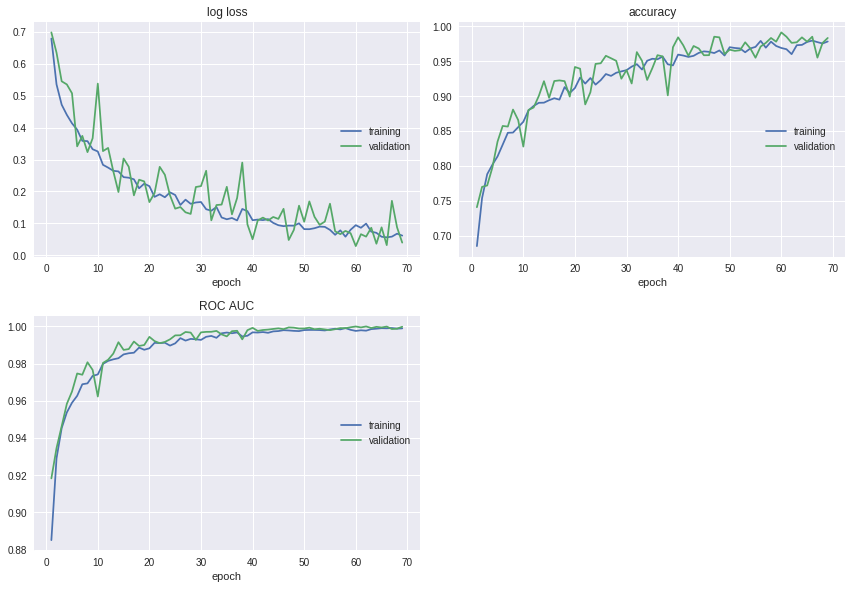


Epoch 70/100 - KFold 5/5


log loss:
training   (min:    0.057, max:    0.679, cur:    0.062)
validation (min:    0.029, max:    0.698, cur:    0.040)

accuracy:
training   (min:    0.685, max:    0.979, cur:    0.978)
validation (min:    0.741, max:    0.991, cur:    0.983)

ROC AUC:
training   (min:    0.885, max:    0.999, cur:    0.999)
validation (min:    0.918, max:    1.000, cur:    1.000)


Items processed: {'melanoma': 1510, 'nevus': 1510, 'seborrheic_keratosis': 1510}
train_loss=0.052, train_acc=0.981, melan_acc=0.979, nevus_acc=0.966, sebor_acc=0.997
Cat 1 ROC AUC: 0.998 Cat 2 ROC AUC: 1.000 Cat 3 ROC AUC: 0.999


Items processed: {'melanoma': 377, 'nevus': 377, 'seborrheic_keratosis': 377}
valid_loss=0.059, valid_acc=0.984, melan_acc=0.958, nevus_acc=0.995, sebor_acc=1.000
Cat 1 ROC AUC: 0.999 Cat 2 ROC AUC: 1.000 Cat 3 ROC AUC: 1.000


Buffered data was truncated after reaching the output size limit.

In [0]:
def train_densenet_model():

  model, image_size = initialize_model('densenet', len(classes), use_pretrained=True)

  return train_model(model, criterion, phase_data_dirs_resized, over_sampling=True, cv=5, 
                     # Freeze denseblock1 and denseblock2
                     # Train  denseblock3 and denseblock4
                     first_trained_module='features.denseblock3', num_epochs=100)

# uncomment the code below to train it from scratch...
# dr_densenet_model = train_densenet_model()

While validation metrics are excellent after 70 epochs, test metrics have more variations ! It overfits to the training/validation set. So I did not keep the very last model. But one of the previous.  

I should also mention that, in the run above, I did not add too much blur, noise and color jitter in train transforms. Hence the validation metrics that reach 1.000 ROC AUC and 99.1% accuracy.  

I kept these (nice) plots because it was one of my longest runs, but the model I kept is from a shorter run, with the data augmentation defined earlier in this book.

# Evaluate the Model

Inspired by the [2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection](https://challenge.kitware.com/#challenge/583f126bcad3a51cc66c8d9a), the algorithm is ranked according to three separate categories:
- Category 1: ROC AUC for Melanoma Classification
- Category 2: ROC AUC for Melanocytic Classification
- Category 3: Mean ROC AUC

The test_model function below calculates the test Mean ROC AUC of the model on the test set.  
It also returns a data frame with the probabilities of detection of melanoma and seborrheic keratoses in the given images.

In [0]:
def test_model(folder, model, criterion, resize=0.75, n_crops=10, plot=False):
  
  if len(logging.getLogger().handlers)==1:
    init_log('test')
    
  data_loader = init_epoch(model, 'test', [folder], n_crops=n_crops)
                         
  _, best_auc, _, accuracy, data = run_epoch('test', data_loader, model, criterion)
  
  file_names = [os.path.basename(fn) for fn in sorted(glob.glob(os.path.join(folder, '*', '*.jpg')))]
  predictions = pd.DataFrame(index=file_names, data=data, columns=classes)
  
  if plot:
    _ = get_roc_auc(y_true, predictions.as_matrix(columns=[classes[0], classes[2]]), plot=True)

  return predictions, accuracy, best_auc

I need to download the ground_truth.csv where true labels are stored for melanoma and seborrheic keratoses.

In [0]:
!wget -q -O ground_truth.csv https://raw.githubusercontent.com/sebastienlange/dermatologist-ai/master/ground_truth.csv

In [0]:
def get_ground_truth():
    # get ground truth labels for test dataset
    truth = pd.read_csv('ground_truth.csv')
    y_true = truth.as_matrix(columns=["task_1", "task_2"])
    return y_true
  
y_true = get_ground_truth()

Let's load my trained DenseNet model and name it __Dr DenseNet model__ 😉

In [0]:
def load_model(state_dict_fn):
  
  if os.path.exists(os.path.join(os.getcwd(), state_dict_fn)):
    # already downloaded
    state_dict_fn = os.path.join(os.getcwd(), state_dict_fn)
  elif os.path.exists(os.path.join(google_drive_shared_path, state_dict_fn)):
    # available on my own google drive
    state_dict_fn = os.path.join(google_drive_shared_path, state_dict_fn)
  else:
    state_dict_fn = os.path.join(os.getcwd(), state_dict_fn)
    download_file(state_dict_fn, quiet=True)
  
  model, image_size = initialize_model(get_model_name(state_dict_fn).lower(), len(classes))
  model.load_state_dict(torch.load(state_dict_fn))
  
  return model

def release_model(model):
  # free GPU memory
  
  del model
  torch.cuda.empty_cache()

In [0]:
def get_model_name(fn):
  
  model_name = fn.split(os.path.sep)[-1].split('_')[0].split('.')[0]
  
  return f'{model_name}154' if model_name.lower()=='senet' else model_name

In [72]:
dr_densenet_model = load_model('DenseNet.pt')

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.torch/models/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:04<00:00, 24255954.62it/s]


Now we are ready to __evaluate Dr DenseNet Model__, plot __ROC AUC__ and see how it performs!

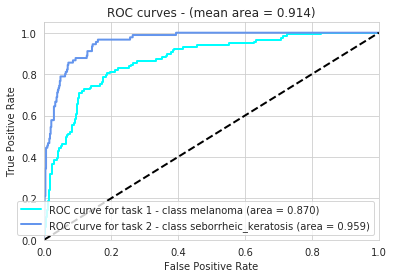

Category 1 Score: 0.870
Category 2 Score: 0.959
Category 3 Score: 0.914


In [73]:
predictions, accuracy, best_auc = test_model(data_dir['test'] + '_resized', dr_densenet_model, criterion, plot=True)

__0.914__! Well done!!!

__Dr. DenseNet__ is an excellent Doctor, with excellent results!  If he had participated in the [2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection](https://challenge.kitware.com/#challenge/583f126bcad3a51cc66c8d9a), he __would have reached the TOP 1__ with a 0.003 gain over the highest score!

But it's still a human and sometimes he makes mistakes. As I am a rather anxious person, I would prefer to __ask for a second medical opinion__... (My fifth mistake was to be too confident in one single doctor 😉)

In [0]:
release_model(dr_densenet_model)

# Go Further

## Second Medical Opinion

So let's seek for a second medical opinion from __Dr. [Inception v3](https://arxiv.org/abs/1512.00567)__.  

![Inception v3](https://cdn-images-1.medium.com/max/960/1*gqKM5V-uo2sMFFPDS84yJw.png)

Note that I again need to specify the layers I want to freeze and the ones I want to train. I choose to freeze until layer named Mixed_4.

In [0]:
def train_inception3_model():
  
  model, image_size = initialize_model('inception3', len(classes), use_pretrained=True)

  batch_size['train'] = 128
  
  return train_model(model, criterion, phase_data_dirs_resized, over_sampling=False, cv=5,
                     first_trained_module='Mixed_5c', num_epochs=100, fine_tuning_module_rounds=2)

# uncomment the code below to train it from scratch...
# dr_inception_model = train_inception3_model()

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.torch/models/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:03<00:00, 29490995.01it/s]

Test 10-crops


Items processed: ['melanoma: 117', 'nevus: 393', 'seborrheic_keratosis: 90']
test_loss=0.824, test_acc=0.752, melan_acc=0.803, nevus_acc=0.725, sebor_acc=0.800
Cat 1 ROC AUC: 0.867 Cat 2 ROC AUC: 0.956 Cat 3 ROC AUC: 0.911


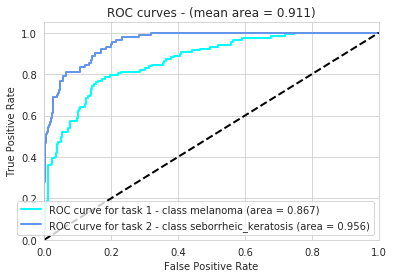

Category 1 Score: 0.867
Category 2 Score: 0.956
Category 3 Score: 0.911


In [77]:
# load my highest Inception3 score
dr_inception_model = load_model('Inception3_3_0.9089.pt')
predictions, accuracy, best_auc = test_model(data_dir['test'] + '_resized', dr_inception_model, criterion, plot=True)

Same score as the winner of the challenge for Dr Inception!

In [0]:
release_model(dr_inception_model)

## Third Medical Opinion

I now have two medical opinions! Great! But __Dr. DenseNet and Dr. Inception sometimes gives me opposite opinion!__  
So let's look for a third medical opinion that will be able to decide: __Dr. [NASNetALarge](https://arxiv.org/abs/1707.07012) arrives on stage!__  

As stated in the [paper](https://arxiv.org/abs/1707.07012) that describes it, this is the __most accurate architecture__ as of April 2018:

![NasNet performance](https://1.bp.blogspot.com/-E1qM-CKq-BA/WfuGc22fPBI/AAAAAAAACIg/frpwbO5Jh-oL0cSObyJa29fXkBsuVl7CACLcBGAs/s640/image3.jpg)

Again I need to specify the layers I want to freeze and the ones I want to train. I choose to freeze until layer named cell_4.  

Ok it is the most accurate, but as the name suggests: it is large, very large. I'm not sure I'm patient enough to train it successfully. And anyway, I arbitrarily set the cursor to decide which layers to freeze and which to train: I choose to freeze until the layer named cell_4.  

And last thing ... Google Colab __lacks GPU memory__ to train it worthily! I have to __reduce the train batch size to 12__.

In [0]:
batch_size = {phase: 12 if phase=='train' else 2 for phase in phases}

def train_nasnetalarge_model():
  
  model, image_size = initialize_model('nasnetalarge', len(classes), use_pretrained=True)

  return train_model(model, criterion, phase_data_dirs_resized, over_sampling=True, cv=5,
                     first_trained_module='cell_4', num_epochs=100)

# uncomment the code below to train it from scratch...
# dr_nasnetalarge_model = train_nasnetalarge_model()


Test 10-crops


Items processed: ['melanoma: 117', 'nevus: 393', 'seborrheic_keratosis: 90']
test_loss=0.823, test_acc=0.742, melan_acc=0.803, nevus_acc=0.715, sebor_acc=0.778
Cat 1 ROC AUC: 0.874 Cat 2 ROC AUC: 0.954 Cat 3 ROC AUC: 0.914


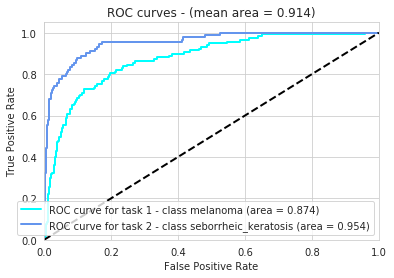

Category 1 Score: 0.874
Category 2 Score: 0.954
Category 3 Score: 0.914


In [85]:
# load my highest NASNetALarge score
dr_nasnetalarge_model = load_model('NASNetALarge_4_0.9106.pt')
predictions, accuracy, best_auc = test_model(data_dir['test'] + '_resized', dr_nasnetalarge_model, criterion, plot=True)

0.914! High score for Dr NasNetALarge!

In [0]:
release_model(dr_nasnetalarge_model) 

## Just another one for fun

Hey, I can not help but seek __Dr. Xception's__ medical opinion! 😁

In [0]:
batch_size = {phase: 48 if phase=='train' else 16 for phase in phases}

def train_xception_model():
  
  model, image_size = initialize_model('xception', len(classes), use_pretrained=True)

  return train_model(model, criterion, phase_data_dirs_resized, over_sampling=True, cv=5,
                                  first_trained_module='block4', num_epochs=100)

# uncomment the code below to train it from scratch...
# dr_xception_model = train_xception_model()

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth" to /root/.torch/models/xception-43020ad28.pth
100%|██████████| 91675053/91675053 [04:17<00:00, 355530.04it/s]

Test 10-crops


Items processed: ['melanoma: 117', 'nevus: 393', 'seborrheic_keratosis: 90']
test_loss=0.873, test_acc=0.817, melan_acc=0.641, nevus_acc=0.870, sebor_acc=0.811
Cat 1 ROC AUC: 0.870 Cat 2 ROC AUC: 0.955 Cat 3 ROC AUC: 0.913


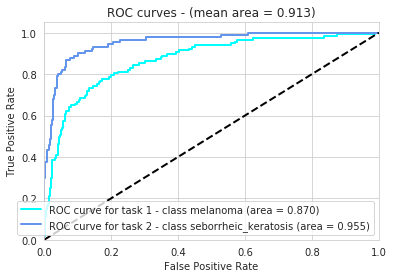

Category 1 Score: 0.870
Category 2 Score: 0.955
Category 3 Score: 0.913


In [88]:
# load my highest Xception score
dr_xception_model = load_model('Xception_1_block4_0.9120.pt')
predictions, accuracy, best_auc = test_model(data_dir['test'] + '_resized', dr_xception_model, criterion, plot=True)

0.913! And still a first place for Dr Xception!

In [0]:
release_model(dr_xception_model) 

## Committee of Doctors

I'm lucky enough to bring together my four doctors in a committee! Alone, they all fit in the TOP 1! What a dream team!

They share their results, debate, and __Dr. Inception comes to suggest looking at the dermatoscopic images from different perspectives__.  

He suggest the following crops:

In [0]:
crops = [1, 5, 10, 20]

But wait a minute ... actually I just had a __hard time stopping to learn and try other ideas and other models ...__ 😅  

In [75]:
#@title
from IPython.display import HTML

def get_unique_models_count(model_names):
  
  return len(set(model_names))

trained_models = list(trained_models_files.keys())
HTML(f"In the end, I kept {len(trained_models)} trials from <b>{get_unique_models_count([get_model_name(fn) for fn in trained_models_files.keys()])} unique models</b>, each tested at {len(crops)} different crops {crops}, this makes a total of <b>{len(trained_models)*len(crops)} different perspectives</b>. It's too much.<p>Lets' choose some <b>threshold to eliminate the worst ones</b>:")

In [0]:
def threshold_results(roc_auc_value, accuracy):
  
  accuracy = accuracy if type(accuracy)==float or type(accuracy)==np.float64 else compute_accuracy(accuracy)
  
  return (round(roc_auc_value,3) >= 0.907 and round(accuracy,2)>=0.75) \
       or round(roc_auc_value,3) > 0.911 \
       or round(accuracy,2) >= 0.80

Here's the code to test one model at different crops... and save results to disk so that I test it once for all...

In [0]:
def test_model_with(folder, crops, fn, criterion):
  # test model once per given crop
  
  all_predictions = {}
  model = None
  
  for crop in crops:
    
    results_fn = fn.replace('.pt', f'-{crop}-crops.csv')
    
    if os.path.exists(os.path.join(os.getcwd(), 'results', results_fn)):
      results_fn = os.path.join(os.getcwd(), 'results', results_fn)
    elif os.path.exists(os.path.join(google_drive_shared_path, 'results', results_fn)):
      results_fn = os.path.join(google_drive_shared_path, 'results', results_fn)
    else:
      download_fn = 'https://raw.githubusercontent.com/sebastienlange/dermatologist-ai/master/results/' + results_fn
      results_root = os.path.join(os.getcwd(), 'results')
      !wget -q $download_fn -P $results_root
      results_fn = os.path.join(os.getcwd(), 'results', results_fn)
    
    if os.path.exists(results_fn):
      predictions = pd.read_csv(results_fn)
      best_auc, accuracy = compute_scores(predictions.as_matrix(columns=[classes[0], classes[1], classes[2]]))
      print(f'\Loaded results from {results_fn}: accuracy = {accuracy:.3f} - ROC AUC Cat3 = {best_auc:0.3f}')
      
    else:
      if model is None:
        model = load_model(fn)
      
      # make batch_size inversely proportional to the crop and compatible with biggest models... otherwise CUDA out of memory ;-)
      batch_size['test'] = int(40 / crop)
      
      print(f'\nTesting {fn} with {crop}-crops')
      predictions, accuracy, best_auc = test_model(folder, model, criterion, n_crops=crop)
      
      # test once for all... it takes time :-)
      path_to_save = os.path.join(google_drive_shared_path if os.path.exists(google_drive_shared_path) else os.getcwd(), 'results')
      predictions.to_csv(os.path.join(path_to_save, fn.replacefn.replace('.pt', f'-{crop}-crops.csv')))     
      
    all_predictions[crop] = (predictions, accuracy, best_auc)
    
  if model is not None:
    release_model(model)
      
  return all_predictions

def compute_scores(predictions, plot=False):

  combined_roc_auc = get_roc_auc(y_true, predictions[:, [0,2]], plot=plot)[2]
  combined_accuracy = sum(y == np.argmax(predictions, axis=1))/predictions.shape[0]
  
  return combined_roc_auc, combined_accuracy

Let's create some functions to display individual results:

In [160]:
#@title
HTML(f"Now I load my <b>{len(trained_models)} trials</b>... and test them at {len(crops)} different crops {crops}. <b>It takes a few hours without the csv results files</b>...")

In [161]:
#@title
# test all models with given crops
y = get_true_labels([data_dir['test']])
predictions = {i:test_model_with(data_dir['test'] + '_resized', crops, fn, criterion) for i, fn in enumerate(trained_models)}

\Loaded results from /content/results/DenseNet-1-crops.csv: accuracy = 0.750 - ROC AUC Cat3 = 0.909
\Loaded results from /content/results/DenseNet-5-crops.csv: accuracy = 0.757 - ROC AUC Cat3 = 0.911
\Loaded results from /content/results/DenseNet-10-crops.csv: accuracy = 0.755 - ROC AUC Cat3 = 0.914
\Loaded results from /content/results/DenseNet-20-crops.csv: accuracy = 0.753 - ROC AUC Cat3 = 0.914
\Loaded results from /content/results/Inception3_3_0.9051-1-crops.csv: accuracy = 0.777 - ROC AUC Cat3 = 0.897
\Loaded results from /content/results/Inception3_3_0.9051-5-crops.csv: accuracy = 0.788 - ROC AUC Cat3 = 0.905
\Loaded results from /content/results/Inception3_3_0.9051-10-crops.csv: accuracy = 0.790 - ROC AUC Cat3 = 0.907
\Loaded results from /content/results/Inception3_3_0.9051-20-crops.csv: accuracy = 0.797 - ROC AUC Cat3 = 0.907
\Loaded results from /content/results/Inception3_3_0.9089-1-crops.csv: accuracy = 0.727 - ROC AUC Cat3 = 0.906
\Loaded results from /content/results/Inc

Here are their individual scores with different crops:

In [162]:
#@title
def get_summary_row(test_result, n_crop, model_name):
    
  return [f'Dr. {model_name}', 
          n_crop, 
          np.round(test_result[1] if type(test_result[1])==float or type(test_result[1])==np.float64 else compute_accuracy(test_result[1]), 3), 
          np.round(test_result[2], 3)]

def append_summary_row(summary, new_row, background=''):
  
  return summary.append({'Model': f'<b>{new_row[0]}</b>', 
                'Crop':f'{new_row[1]}', 
                'Accuracy': '<b{0}>{1:.3f}</b>'.format(background, new_row[2]),
                'Cat 3 ROC AUC': '<b{0}>{1:.3f}</b>'.format(background, new_row[3])
                         }, ignore_index=True)

def create_summary(predictions, trained_model_names, crops):
  
  data = [get_summary_row(predictions[model_idx][crop], crop, trained_model_names[model_idx]) for crop in crops for model_idx in range(len(trained_models))
         if threshold_results(predictions[model_idx][crop][2], predictions[model_idx][crop][1])]
  summary = pd.DataFrame(data=data, columns=['Model', 'Crop', 'Accuracy', 'Cat 3 ROC AUC'])
  summary = summary.sort_values(by=['Cat 3 ROC AUC', 'Accuracy', 'Model'], ascending=[False, False, True])
  summary = append_summary_row(summary, ['Mean', '', summary['Accuracy'].mean(), summary['Cat 3 ROC AUC'].mean()])
  
  return summary

summary = create_summary(predictions, trained_models, crops)
HTML(summary.to_html(escape=False))

,Model,Crop,Accuracy,Cat 3 ROC AUC
0,Dr. DenseNet.pt,10,0.755,0.914
1,Dr. DenseNet.pt,20,0.753,0.914
2,Dr. NASNetALarge_4_0.9106.pt,10,0.742,0.914
3,Dr. Xception_1_block4_0.9120.pt,10,0.817,0.913
4,Dr. SENet_3_layer2.1_0.8988.pt,20,0.793,0.913
5,Dr. InceptionV4_2_features.6.branch1.0_0.9117.pt,20,0.755,0.913
6,Dr. Xception_1_block4_0.9120.pt,5,0.817,0.912
7,Dr. SENet_3_layer2.1_0.8988.pt,10,0.792,0.912
8,Dr. Inception3_3_0.9089.pt,20,0.76,0.912
9,Dr. InceptionV4_2_features.6.branch1.0_0.9117.pt,5,0.747,0.912


In [117]:
#@title
mean_auc = summary.iloc[-1]['Cat 3 ROC AUC']
min_auc = np.min([item for item in summary['Cat 3 ROC AUC'][:-1]])
max_auc = np.max([item for item in summary['Cat 3 ROC AUC'][:-1]])
#mean_auc = summary.iloc[-1]['Cat 3 ROC AUC'].item()
HTML(f'So the chosen threshold enables to select the {len(summary)-1} best persepectives out of {len(trained_models)*len(crops)} available.<p>Their individual Cat 3 ROC AUC range from <b>{min_auc} to {max_auc}</b>, with an <b>average of {mean_auc}</b>.')

### Build the best team

My sixth mistake was to try immediately to give a different weight to my prefered Dr. (and most trained) and yet different weights to the scales 😉.

Giving it a try is not a mistake! It's to start with a complex algorithm that makes the mistake.

There is a very __simple algorithm to try here__: let's give equal value to each perspective and extract for each image the __mean of all probabilities__.  

However, I do not mean all the trials, but I mean n-combinations from unique architectures (each Dr. has a single and equal voting right):


In [118]:
#@title
import itertools

def get_combined_predictions(predictions_by_model, combination):
  
  sub_predictions_by_model = {(model_idx, crop):predictions_by_model[(model_idx, crop)] for (model_idx,crop) in combination }
  
  # for every image, I calculate the mean probability of my combinations
  return np.mean(list(sub_predictions_by_model.values()), axis=0)

def step(x, threshold=0):
    return np.sign(np.sign(x-threshold)+1)

def minimum_cost_threshold(y_true, y_pred, costs=(1, 1)):
    '''
    Find the decision threshold that minimizes the cost of errors.
    
    costs=(false_positive_cost, false_negative_cost)
    '''
    def error(x, costs):
        return costs[0]*step(-x, 0.99) + costs[1]*step(x,0.99)
    costs = np.array(costs)
    costs = costs/np.sum(costs)
    min_cost = np.inf
    min_threshold = 0
    for threshold in np.arange(0, 1, 0.001):
        y_pred_bin = np.ceil(y_pred - threshold)
#         cost = np.abs(y_true - y_pred_bin)*np.apply_along_axis(lambda i: costs[i[0]], 0, y_true)
        cost = error(y_true-y_pred_bin, costs)
        if np.mean(cost) < min_cost:
#             print(cost[:10])
            min_cost = np.mean(cost)
            min_threshold = threshold
    return min_threshold
  
def get_models_and_crops(combination):
  return sorted([f'{trained_models[model_idx]} ({crop}-crops)' for (model_idx,crop) in combination])
  
def get_predictions_list(combination):
  return list({(model_idx, crop):predictions_by_model[(model_idx, crop)] for (model_idx,crop) in combination }.values())
  
def process_combination(combination, very_best_auc, best_melanoma_f1_threshold, best_seborreric_f1_threshold, very_best_comb):
  
  # keep only combinations with unique architecture
  if get_unique_models_count([get_model_name(trained_models[i]) for (i,crop) in combination]) == len(combination):
    
    combined_predictions = get_combined_predictions(predictions_by_model, combination)
    combined_roc_auc, combined_accuracy = compute_scores(combined_predictions)
    
    auc_data.append({'ROC AUC': combined_roc_auc, 'multi-model': n, 'type': 'mean', 'crop': (combination[0][1] if len(combination)==1 else '')})        

    seq = [x['ROC AUC'] for x in auc_data if x['multi-model']==n]
    current_min = np.min(seq)
    current_max = np.max(seq) 

    if combined_roc_auc == current_max or combined_roc_auc == current_min:
      tqdm_items.set_postfix_str(f'ROC AUC min.-max.: {current_min:0.3f}-{current_max:0.3f}')
      
    # scores are sorted by roc_auc, melanoma_f1_threshold, seborreric_f1_threshold
    round_combined_roc_auc = round(combined_roc_auc,3)
    if round_combined_roc_auc >= very_best_auc:

      melanoma_f1_threshold = round(minimum_cost_threshold(y_true[:, 0], combined_predictions[:, 0], costs=(1,10)),3)
      if round_combined_roc_auc > very_best_auc or melanoma_f1_threshold >= best_melanoma_f1_threshold:
        seborreric_f1_threshold = round(minimum_cost_threshold(y_true[:, 1], combined_predictions[:, 2], costs=(1,10)),3)
        if melanoma_f1_threshold > best_melanoma_f1_threshold or seborreric_f1_threshold >= seborreric_f1_threshold:

          if very_best_auc == 0:

            print('High scores')
            print('------|---------|---------|----------|--------------------------------------------------------------------------------------------------')
            print(' ROC  | F1 mel. | F1 seb. | Accuracy | Models (n-crops)')
            print(' AUC  | thresh. | thresh. |          |')
            print('------|---------|---------|----------|--------------------------------------------------------------------------------------------------')

          very_best_auc = round_combined_roc_auc
          best_melanoma_f1_threshold = melanoma_f1_threshold
          best_seborreric_f1_threshold = seborreric_f1_threshold
          very_best_comb = combination
          
          if len(combination) > 1:
            models_and_crops = get_models_and_crops(combination)
            models_and_crops = ' + '.join(models_and_crops)
            print(f'{combined_roc_auc:.3f} |  {best_melanoma_f1_threshold:.3f}  |  {best_seborreric_f1_threshold:.3f}  |  {combined_accuracy:.3f}   | {models_and_crops}')
             
  return very_best_auc, best_melanoma_f1_threshold, best_seborreric_f1_threshold, very_best_comb  

print('Analyzing combinations of models...')

predictions_by_model = {(model_idx, crop): predictions[model_idx][crop][0].as_matrix(columns=[classes[0], classes[1], classes[2]]) 
                        for crop in crops for model_idx in range(len(trained_models))
                        if threshold_results(predictions[model_idx][crop][2], predictions[model_idx][crop][1])}

auc_data = []

auc_meaning = [classes[0], classes[2], 'mean']
very_best_auc = 0
very_best_melanoma_f1_threshold = 0
very_best_seborreric_f1_threshold = 0
very_best_comb = ()

unique_fn = set([item.replace('Dr. ', '') for item in summary['Model'][:-1]])
n_unique_architectures = get_unique_models_count([get_model_name(fn) for fn in unique_fn])

try:
  for n in np.arange(1, n_unique_architectures+1):      
    print('\n' + f'Combining {n} models out of {len(predictions_by_model)} from {n_unique_architectures} unique architectures...')

    best_melanoma_f1_threshold = 0
    best_seborreric_f1_threshold = 0
    
    combinations = list(itertools.combinations(predictions_by_model.keys(), n))
    tqdm_items = tqdm(combinations)

    for combination in tqdm_items:
      very_best_auc, best_melanoma_f1_threshold, best_seborreric_f1_threshold, very_best_comb = process_combination(combination, very_best_auc, best_melanoma_f1_threshold, best_seborreric_f1_threshold, very_best_comb) 

except KeyboardInterrupt:
    pass    


Analyzing combinations of models...

Combining 1 models out of 23 from 7 unique architectures...


High scores
------|---------|---------|----------|--------------------------------------------------------------------------------------------------
 ROC  | F1 mel. | F1 seb. | Accuracy | Models (n-crops)
 AUC  | thresh. | thresh. |          |
------|---------|---------|----------|--------------------------------------------------------------------------------------------------

Combining 2 models out of 23 from 7 unique architectures...


0.925 |  0.032  |  0.017  |  0.808   | DenseNet.pt (1-crops) + Xception_1_block4_0.9120.pt (1-crops)
0.925 |  0.124  |  0.019  |  0.777   | DenseNet.pt (1-crops) + InceptionV4_2_features.6.branch1.0_0.9117.pt (1-crops)
0.929 |  0.033  |  0.020  |  0.812   | DenseNet.pt (1-crops) + Xception_1_block4_0.9120.pt (5-crops)
0.930 |  0.069  |  0.169  |  0.825   | NASNetALarge.pt (10-crops) + Xception_1_block4_0.9120.pt (1-crops)
0.930 |  0.081  |  0.015  |  0.793   | Inception3_3_0.9051.pt (20-crops) + InceptionV4_2_features.6.branch1.0_0.9117.pt (1-crops)
0.931 |  0.075  |  0.017  |  0.815   | SENet_3_layer2.1_0.8988.pt (5-crops) + Xception_1_block4_0.9120.pt (5-crops)
0.933 |  0.057  |  0.169  |  0.827   | NASNetALarge.pt (10-crops) + Xception_1_block4_0.9120.pt (5-crops)
0.933 |  0.105  |  0.023  |  0.822   | SENet_3_layer2.1_0.8988.pt (20-crops) + Xception_1_block4_0.9120.pt (5-crops)

Combining 3 models out of 23 from 7 unique architectures...


0.934 |  0.081  |  0.333  |  0.827   | DenseNet.pt (1-crops) + NASNetALarge.pt (10-crops) + Xception_1_block4_0.9120.pt (1-crops)
0.934 |  0.100  |  0.144  |  0.800   | DenseNet.pt (1-crops) + InceptionV4_2_features.6.branch1.0_0.9117.pt (1-crops) + Xception_1_block4_0.9120.pt (5-crops)
0.934 |  0.148  |  0.079  |  0.805   | DenseNet.pt (1-crops) + Inception3_3_0.9051.pt (10-crops) + InceptionV4_2_features.6.branch1.0_0.9117.pt (1-crops)
0.935 |  0.108  |  0.117  |  0.785   | DenseNet.pt (1-crops) + InceptionV4_2_features.6.branch1.0_0.9117.pt (1-crops) + NASNetALarge.pt (10-crops)
0.936 |  0.072  |  0.338  |  0.827   | DenseNet.pt (1-crops) + NASNetALarge.pt (10-crops) + Xception_1_block4_0.9120.pt (5-crops)
0.936 |  0.220  |  0.118  |  0.810   | DenseNet.pt (1-crops) + NASNetALarge.pt (10-crops) + Xception_1_block4_0.9076.pt (10-crops)
0.937 |  0.090  |  0.198  |  0.820   | InceptionV4_2_features.6.branch1.0_0.9117.pt (1-crops) + NASNetALarge.pt (10-crops) + Xception_1_block4_0.9120.

0.939 |  0.090  |  0.257  |  0.810   | DenseNet.pt (1-crops) + InceptionV4_2_features.6.branch1.0_0.9117.pt (1-crops) + NASNetALarge.pt (10-crops) + Xception_1_block4_0.9120.pt (1-crops)
0.939 |  0.097  |  0.239  |  0.807   | DenseNet.pt (1-crops) + InceptionV4_2_features.6.branch1.0_0.9117.pt (5-crops) + NASNetALarge.pt (10-crops) + Xception_1_block4_0.9120.pt (1-crops)
0.941 |  0.086  |  0.252  |  0.807   | DenseNet.pt (1-crops) + InceptionV4_2_features.6.branch1.0_0.9117.pt (1-crops) + NASNetALarge.pt (10-crops) + Xception_1_block4_0.9120.pt (5-crops)
0.941 |  0.087  |  0.251  |  0.810   | DenseNet.pt (1-crops) + InceptionV4_2_features.6.branch1.0_0.9117.pt (1-crops) + NASNetALarge.pt (10-crops) + Xception_1_block4_0.9120.pt (10-crops)
0.941 |  0.089  |  0.248  |  0.803   | DenseNet.pt (1-crops) + InceptionV4_2_features.6.branch1.0_0.9117.pt (5-crops) + NASNetALarge.pt (10-crops) + Xception_1_block4_0.9120.pt (5-crops)
0.942 |  0.087  |  0.203  |  0.808   | DenseNet.pt (10-crops) + 

0.942 |  0.116  |  0.195  |  0.817   | DenseNet.pt (1-crops) + InceptionV4_2_features.6.branch1.0_0.9117.pt (1-crops) + NASNetALarge.pt (10-crops) + SENet_3_layer2.1_0.8988.pt (5-crops) + Xception_1_block4_0.9120.pt (5-crops)
0.942 |  0.123  |  0.193  |  0.823   | DenseNet.pt (1-crops) + InceptionV4_2_features.6.branch1.0_0.9117.pt (1-crops) + NASNetALarge.pt (10-crops) + SENet_3_layer2.1_0.8988.pt (20-crops) + Xception_1_block4_0.9120.pt (5-crops)
0.943 |  0.112  |  0.205  |  0.815   | DenseNet.pt (5-crops) + InceptionV4_2_features.6.branch1.0_0.9117.pt (1-crops) + NASNetALarge.pt (10-crops) + SENet_3_layer2.1_0.8988.pt (20-crops) + Xception_1_block4_0.9120.pt (5-crops)
0.943 |  0.116  |  0.200  |  0.812   | DenseNet.pt (10-crops) + InceptionV4_2_features.6.branch1.0_0.9117.pt (1-crops) + NASNetALarge.pt (10-crops) + SENet_3_layer2.1_0.8988.pt (5-crops) + Xception_1_block4_0.9120.pt (5-crops)
0.943 |  0.121  |  0.205  |  0.817   | DenseNet.pt (10-crops) + InceptionV4_2_features.6.bran

0.943 |  0.100  |  0.219  |  0.832   | DenseNet.pt (1-crops) + Inception3_3_0.9051.pt (10-crops) + InceptionV4_2_features.6.branch1.0_0.9117.pt (1-crops) + NASNetALarge.pt (10-crops) + SENet_3_layer2.1_0.8988.pt (5-crops) + Xception_1_block4_0.9120.pt (5-crops)
0.943 |  0.104  |  0.219  |  0.832   | DenseNet.pt (1-crops) + Inception3_3_0.9051.pt (10-crops) + InceptionV4_2_features.6.branch1.0_0.9117.pt (1-crops) + NASNetALarge.pt (10-crops) + SENet_3_layer2.1_0.8988.pt (20-crops) + Xception_1_block4_0.9120.pt (5-crops)
0.943 |  0.118  |  0.219  |  0.828   | DenseNet.pt (1-crops) + Inception3_3_0.9051.pt (10-crops) + InceptionV4_2_features.6.branch1.0_0.9117.pt (20-crops) + NASNetALarge.pt (10-crops) + SENet_3_layer2.1_0.8988.pt (20-crops) + Xception_1_block4_0.9120.pt (5-crops)
0.943 |  0.128  |  0.183  |  0.827   | DenseNet.pt (1-crops) + Inception3_3_0.9051.pt (10-crops) + InceptionV4_2_features.6.branch1.0_0.9117.pt (20-crops) + NASNetALarge.pt (10-crops) + SENet_3_layer2.1_0.8988.p

### Final scores

In [119]:
#@title
def get_crops(m):
  return m.split('(')[1].split('-')[0]

def get_fn(m):
  return m.split('(')[0].strip()

def get_score(fn, crop):
  return summary[(summary['Model']==f'Dr. {fn}') & (summary['Crop']==int(crop))].iloc[0]['Cat 3 ROC AUC']

def print_team(name, note, combination, score):
  return f'The <b>{name} reached a score of {score:0.3f}</b> and consists of:<p><i>{note}</i><p><ol><li>' + '<li>'.join([f'<b>Dr. {get_model_name(get_fn(m))}</b> ({get_crops(m)}-crops) with an individual score of <b>{get_score(get_fn(m), get_crops(m))}</b> from trial {get_fn(m)}</li>' for m in sorted(get_models_and_crops(combination))]) + '</ol>'
  
HTML(print_team('very best team(*)', '(*) based on ROC AUC score only', very_best_comb, very_best_auc))

Very best ROC AUC scores:


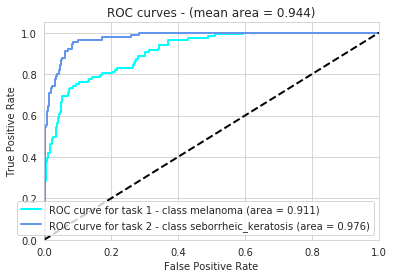

Category 1 Score: 0.911
Category 2 Score: 0.976
Category 3 Score: 0.944


In [123]:
#@title
print('Very best ROC AUC scores:')
combined_predictions = get_combined_predictions(predictions_by_model, very_best_comb)
combined_roc_auc, combined_accuracy = compute_scores(combined_predictions, True)

Wow!  Great!  

__Mean ROC AUC score climbs to 0.944 and outperforms the first score of the initial challenge!__

Editor's note: before giving a try to multiple models, I had initially written in my conclusions: *"I only tried DenseNet with all parameters freezed! I'm pretty sure that a combination of Resnet / Inception / VGG / DenseNet with some re-trained layers and a [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier. html) would push the limits higher!"*. And I was right! 😃😃😃

While I had the intuition of training multiple models early in this project, I discovered very late (see Comparison with State-of-the-art Approaches in [Review: Inception-v4](https://towardsdatascience.com/review-inception-v4-evolved-from-googlenet-merged-with-resnet-idea-image-classification-5e8c339d18bc)) that this was a __best practice__ called __multi-model__. And this is at the same time I discovered and implemented __multi-crop__ in test while I already had implemented __multi-scale__ but I did not keep it.

Multi-model selected with a good compromise between ROC AUC and min. cost threshold for an optimized confusion matrix:


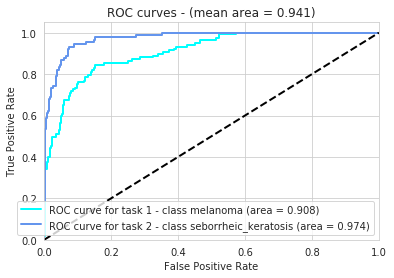

Category 1 Score: 0.908
Category 2 Score: 0.974
Category 3 Score: 0.941


In [129]:
#@title
print('Multi-model selected with a good compromise between ROC AUC and min. cost threshold for an optimized confusion matrix:')

selected_combination = ((trained_models.index('Inception3_3_0.9051.pt'),10),
                      (trained_models.index('NASNetALarge.pt'),10),
                      (trained_models.index('SENet_3_layer2.1_0.8988.pt'),10),
                      (trained_models.index('Xception_1_block4_0.9120.pt'),5))

selected_predictions = get_combined_predictions(predictions_by_model, selected_combination)
selected_roc_auc, selected_accuracy = compute_scores(selected_predictions, True)

In [128]:
#@title
HTML(print_team('selected best team(*)', '(*) based on a good compromise between ROC AUC and min. cost threshold for an optimized confusion matrix', selected_combination, selected_roc_auc))

Best threshold for melanoma: 0.24


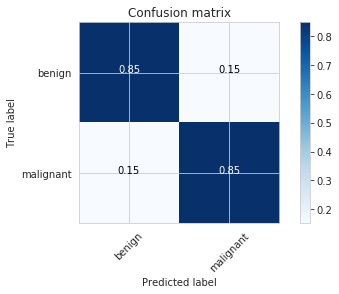

In [130]:
#@title
!wget -q -O get_results.py https://raw.githubusercontent.com/sebastienlange/dermatologist-ai/master/get_results.py

from get_results import plot_confusion_matrix

def plot_best_confusion_matrix(skin_disease, y_true, y_pred, costs=(1,1)):
    threshold = minimum_cost_threshold(y_true, y_pred, costs=costs)
    print(f'Best threshold for {skin_disease}: {threshold:0.2f}')
    plot_confusion_matrix(y_true, y_pred, threshold, ['benign', 'malignant'])
    
plot_best_confusion_matrix(classes[0], y_true[:, 0], selected_predictions[:, 0], costs=(1,10))

Best threshold for seborrheic_keratosis: 0.26


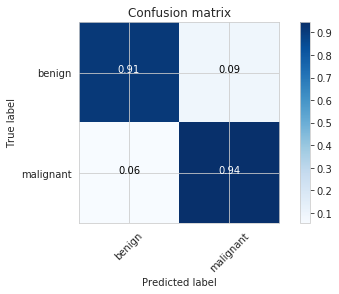

In [131]:
#@title
plot_best_confusion_matrix(classes[2], y_true[:, 1], selected_predictions[:, 2], costs=(1,10))

### Multi-model statistics

I also found interesting to make some statisticts on multi-crop / multi-model scores.

A picture is worth a thousand words! Let's draw a box plot to show __distributions of ROC AUC with respect to number of models__ in the multi-model:

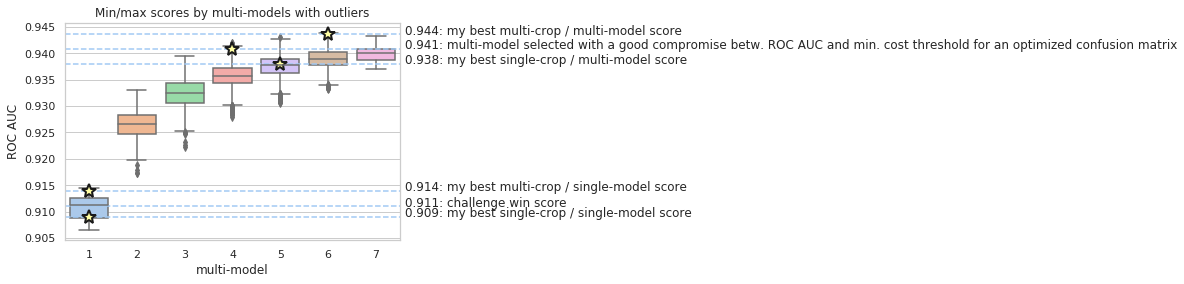

In [110]:
#@title
best_scores = [{'n-model': 1, 'score': summary[summary['Crop']==1].iloc[0]['Cat 3 ROC AUC'], 'description': 'my best single-crop / single-model score'},
               {'score': 0.911, 'description': 'challenge win score'},
               {'n-model': 1, 'score': summary.loc[1]['Cat 3 ROC AUC'], 'description': 'my best multi-crop / single-model score'},
               {'n-model': 5, 'score': 0.938, 'description': 'my best single-crop / multi-model score'},
               {'n-model': len(selected_combination), 'score': selected_roc_auc, 'description': 'multi-model selected with a good compromise betw. ROC AUC and min. cost threshold for an optimized confusion matrix'},
               {'n-model': 6, 'score': combined_roc_auc, 'description': 'my best multi-crop / multi-model score'},
              ]

auc_df = pd.DataFrame(columns=['ROC AUC', 'multi-model', 'type'], data=auc_data)

sns.set(style="whitegrid", palette="pastel", color_codes=True)
ax = sns.boxplot(x="multi-model", y="ROC AUC", data=auc_df)
ax.set_title('Min/max scores by multi-models with outliers')

for best_score in best_scores:
  high_score = best_score['score']
  ax.axhline(high_score, ls='--')
  annotation = ax.text(n_unique_architectures - 0.4, high_score, f'{high_score:0.3f}: ' + best_score['description'])
  if 'n-model' in best_score:
    plt.plot(best_score['n-model']-1, high_score, 'y*', markersize=15, markeredgewidth=2, markeredgecolor='k')

So <b>multi-model gives me ≃3.25% return over investment</b>... whereas multi-crop "only" gives ≃0.6%. But still that adds up 😃  

# Conclusions

I was able to achieve a __Mean ROC AUC score of 0.944__. It would have been a __TOP 1__ in the initial challenge (see scores below). It's very satisfying for what I wanted to achieve, especially since the __winner's score is 0.911__.  😃

But much more than this score, I learned a lot and sometimes the hard way, and took a lot of fun. 😅  

From the first day I reached TOP 3, I said to myself: _"let's publish tomorrow and continue your [Deep Learning nanodegree](https://www.udacity.com/course/deep-learning-nanodegree--nd101). This is an optional mini-project and you're now in a late for the rest of the nanodegree"_... but I just wasn't able to stop training and learning by myself. It took me four more weeks of learning and wonderful experience to go from 0.900 to 0.944.

![title](https://github.com/sebastienlange/dermatologist-ai/blob/master/images/cat_3.png?raw=1)

## Possible points of improvement
Yes! I think it's possible to further improve the results and I still have a lot to learn! 

So here are possible points of improvement:
- test loss is much higher than training/validation loss; although it was not the measure observed during the challenge, I observed it and felt that it was showing too much overfitting to the training/validation set (same for accuracy but to a lesser extent). I need more data!
- more or different __data augmentations__ techniques. Particularly, I integrated [imgaug](https://github.com/aleju/imgaug) lately, so there's __a lot to try with [imgaug](https://github.com/aleju/imgaug)__! Particularly add more noise in image (like improved fake hairs, patch and add fake ruler)
- I chose to divide more or less in two equal parts the number of frozen and trained layers. So, __I'm pretty sure there's a better point than "randomly" choosing first half of layers as frozen and second half as trained layers__
- use different source of images : all the images come from the same distribution
- try [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) with my multi-models, or try further with [XGBClassifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html), or anything else that could do better than a simple mean.
- give more chance to other transfer learning models, and particularly try different parameters: I spent most on my time with DenseNet and I kept the same parameters for others while it could be adapted for each of them...
- fine tune learning rate and other optimizer hyper parameters to speed up gradient descent (Adam with lr 0.002 often worked with earlier versions of the model)
- __detect the area of interest for each image and zoom in on it__.
- give a try to other optimizers: AdaGrad, RMSProp, Adamax, Adadelta...
- try different batch_size to see how it impacts training (the final model reachs a GPU out of memory with a batch size of 64 [Google colab GPU])
- display images where the model fails to understand why it fails and maybe improve algorithm, data augmentation...